# About dataset

Our dataset revolves around key hull geometry coefficients and the Froude number, all tied to the vital residuary resistance per unit weight of displacement. These attributes offer deep insights into the hydrodynamic traits of vessels. The dataset is meticulously crafted to support predictive analysis in maritime engineering.

Features and Target
The dataset encapsulates the following features:

LC (Longitudinal Position of Buoyancy): Dimensionless measure of buoyancy center's longitudinal location.
PC (Prismatic Coefficient): Dimensionless coefficient indicating hull volume distribution.
L/D (Length-Displacement Ratio): Dimensionless ratio of vessel length to displacement.
B/Dr (Beam-Draught Ratio): Dimensionless ratio of hull width to depth.
L/B (Length-Beam Ratio): Dimensionless ratio of hull length to width.
Fr (Froude Number): Dimensionless number characterizing flow regime around the hull.
Target
The focus lies on the dimensionless Rr (Residuary Resistance per Unit Weight of Displacement). This quantifies residual resistance in relation to displacement weight, crucial for assessing hydrodynamic efficiency.

Machine Learning Approach
Our goal is to apply machine learning to predict Rr using hull coefficients and the Froude number. By employing regression algorithms, we aim to create predictive models that enhance our understanding of how these attributes influence hydrodynamic resistance. This analysis promises to uncover valuable insights for informed maritime engineering decisions.

In the following sections, we delve into data preprocessing, model selection, parameter tuning, and performance evaluation to unlock deeper insights into the intricate relationship between hull attributes and hydrodynamic behavior

# Libraries

In [1]:
#Import necessary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import pickle

In [2]:
#call data frame
df=pd.read_csv(r'C:\Users\poory\Desktop\work\projects\Hydrodynamic project\yacht_hydro.csv')

# Preprocessing and visualization

In [3]:
#show five first columns
df.head()

,LC,PC,L/D,B/Dr,L/B,Fr,Rr
0,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
1,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
2,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
3,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
4,-2.3,0.568,4.78,3.99,3.17,0.225,1.18


In [4]:
#describe some statistic information of our dataframe
df.describe()

,LC,PC,L/D,B/Dr,L/B,Fr,Rr
count,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000
mean,-2.381818,0.564136,4.788636,3.936818,3.206818,0.287500,10.495357
std,1.513219,0.023290,0.253057,0.548193,0.247998,0.100942,15.160490
min,-5.000000,0.530000,4.340000,2.810000,2.730000,0.125000,0.010000
25%,-2.400000,0.546000,4.770000,3.750000,3.150000,0.200000,0.777500
50%,-2.300000,0.565000,4.780000,3.955000,3.150000,0.287500,3.065000
75%,-2.300000,0.574000,5.100000,4.170000,3.510000,0.375000,12.815000
max,0.000000,0.600000,5.140000,5.350000,3.640000,0.450000,62.420000


### null values

Handling null values is one of the most challenging aspects of preprocessing. Therefore, it's crucial to identify the number of null values in each column. If null values are present, appropriate strategies should be applied to address them effectively.

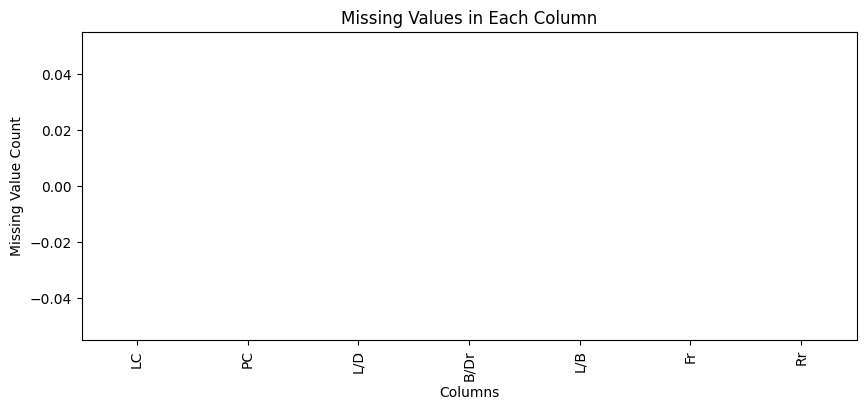

In [5]:
#return the number of null values in each column
missing_values = df.isnull().sum()

#create a barbolt to visualize null values
# Create a bar plot to visualize missing values
plt.figure(figsize=(10, 4))
sns.barplot(x=missing_values.index, y=missing_values.values)
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Missing Value Count')
plt.title('Missing Values in Each Column')
plt.show()


As you can observe, there are no null values present in any of the columns.

### Outliers

outliers is another chalOutliers represent another significant challenge in the preprocessing phase. The presence of outliers within our columns can significantly impact the accuracy of our results, necessitating their careful handling.lenging aspect of preprocessing . Existence outlier in our columns can do effect on our accuracy and must handel it

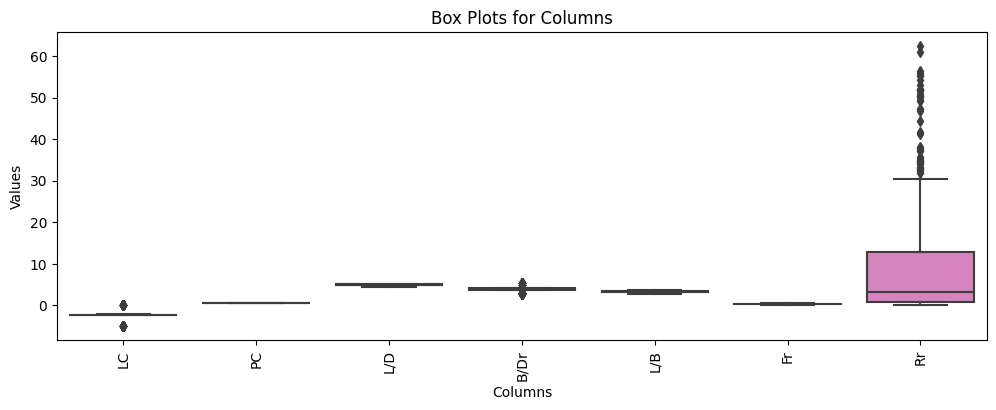

In [6]:
plt.figure(figsize=(12, 4))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Box Plots for Columns')
plt.show()

as you can observe there are outliers present within our columns. Due to the limited number of data points and the sensitivity of our dataset, we refrain from removing or altering these outliers.

### Visualization of Skewness

Skewness poses another significant challenge in preprocessing. In this phase, we examine the standard deviation and skewness of our columns. Detecting deviations from normal distributions, such as a high prevalence of zero values in a specific column, allows us to identify and address potential issues.

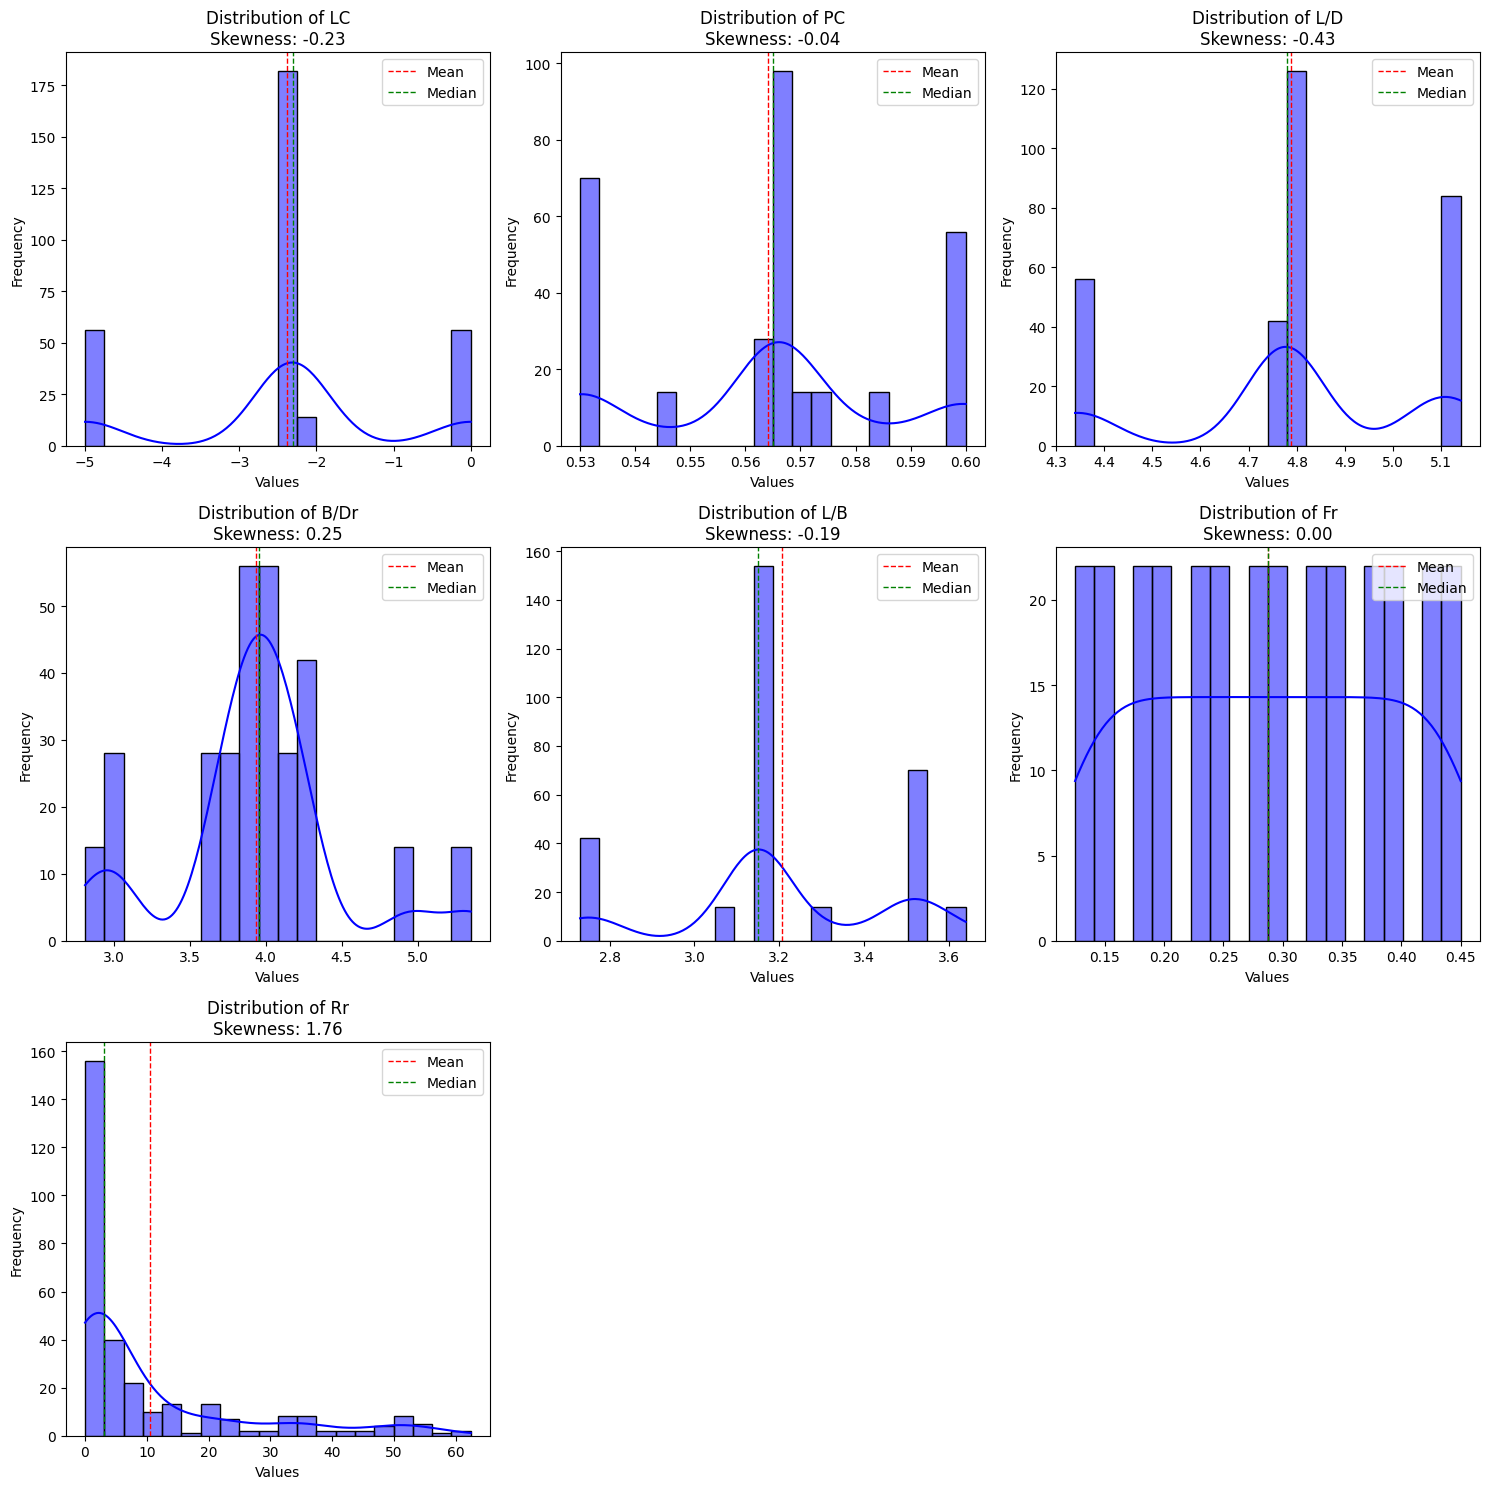

In [7]:
num_cols = 3
num_rows = (df.shape[1] + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
fig.subplots_adjust(hspace=0.5)

# Plot each column in a separate subplot
for i, column in enumerate(df.columns):
    ax = axes[i // num_cols, i % num_cols]
    sns.histplot(data=df[column], ax=ax, bins=20, kde=True, color='blue', edgecolor='k')
    ax.axvline(df[column].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
    ax.axvline(df[column].median(), color='green', linestyle='dashed', linewidth=1, label='Median')
    ax.set_title(f'Distribution of {column}\nSkewness: {df[column].skew():.2f}')
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')
    ax.legend()

# If the last subplot is not used, remove it
if i + 1 < num_rows * num_cols:
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes[j // num_cols, j % num_cols])

plt.tight_layout()
plt.show()

With the exception of the target column Rr, the remaining columns exhibit relatively normal distributions and possess acceptable skewness values. Therefore, there is no immediate need for adjustments in these columns.

### heatmap

Using a heatmap, we can effectively visualize the correlations between columns in our dataset. 

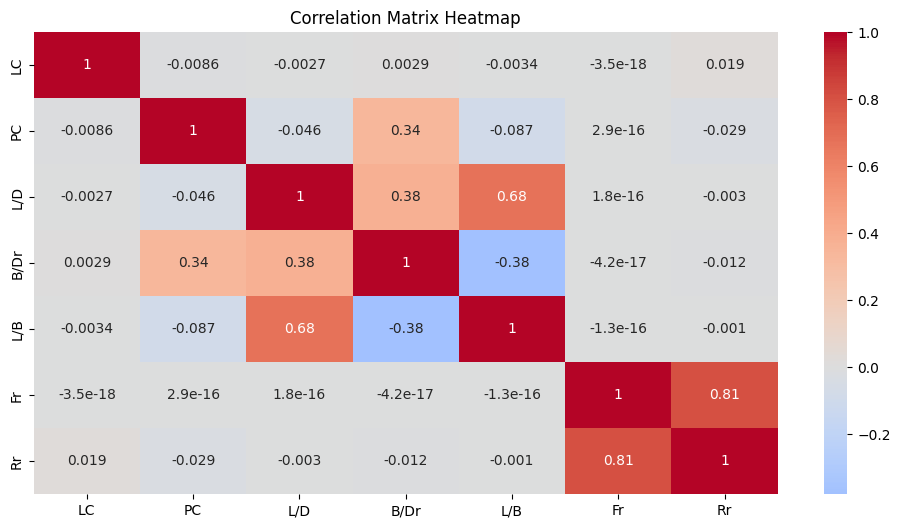

In [8]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

### scatter plot matrix 

This scatter plot matrix showcases relationships between selected columns and the target 'Rr'. Each subplot illustrates how 'Rr' values correspond to variables such as 'LC', 'PC', 'L/D', 'B/Dr', 'L/B', and 'Fr'. The blue color and transparency help distinguish overlapping data points. Subplots are arranged for clarity, with the size adjusted for optimal visualization. This aids in identifying potential correlations and guiding feature selection.

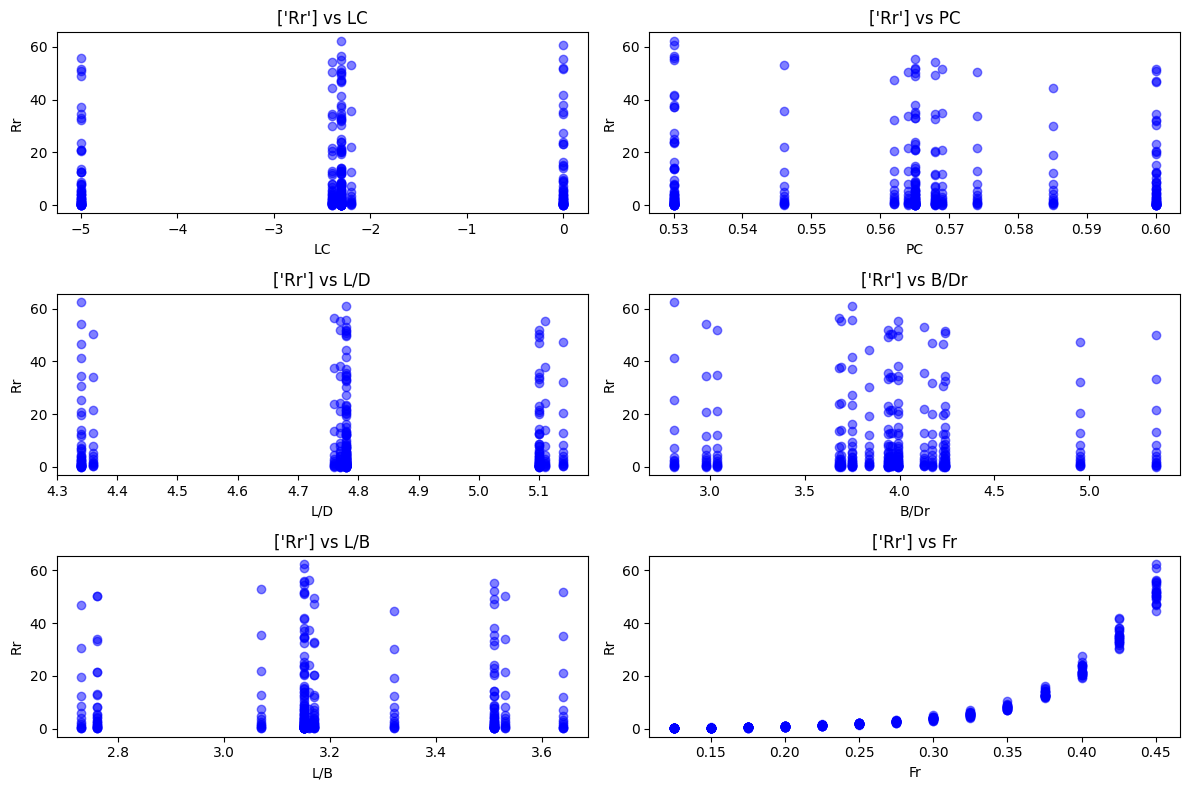

In [9]:
columns_to_compare = ['LC', 'PC', 'L/D', 'B/Dr', 'L/B', 'Fr']
target_column=['Rr']
# Create subplots for each column
num_columns = len(columns_to_compare)
num_rows = (num_columns + 1) // 2
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)

for i, column in enumerate(columns_to_compare):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    ax.scatter(df[column], df['Rr'], color='blue', alpha=0.5)
    ax.set_xlabel(column)
    ax.set_ylabel('Rr')
    ax.set_title(f'{target_column} vs {column}')

# If the number of columns is odd, remove the empty subplot
if num_columns % 2 == 1:
    fig.delaxes(axes[num_rows - 1, 1])

plt.tight_layout()
plt.show()

### Data Preparation and Train-Test Split

In this section, our initial steps involve separating the target variable from the features. As the values in our dataset exhibit an ordered structure from least to most, shuffling is employed to introduce randomness. This randomization ensures that the training and testing sets are representative and not biased by the inherent order of values. The shuffled data is then utilized to create distinct training and testing subsets, setting the foundation for subsequent analysis and modeling.

In [10]:
target=df['Rr']#Extract the 'R2' column as the target
df.drop(['Rr'],axis=1,inplace=True)#Drop the 'R2' column from the Dataframe

In [11]:
#Shuffle features and target using a random seed
x_shuffled, y_shuffled = shuffle(df, target, random_state=42)

In [12]:
#Split shuffled features into train and test sets
x_train,x_test,y_train,y_test=train_test_split(x_shuffled,y_shuffled,test_size=0.3,random_state=42)

In [13]:
y_test

252     0.16
46      1.37
198     0.47
224     0.03
173     1.76
       ...  
170     0.45
94     12.80
168     0.08
2       0.47
208    37.38
Name: Rr, Length: 93, dtype: float64

# Machine learning prediction

In this section, our objective is to leverage machine learning models for predictive analysis. We explore several machine learning algorithms and employ grid search techniques to identify the optimal parameters that yield the best performance. After evaluating various models, we select the one exhibiting the highest accuracy for our project's needs. Our chosen evaluation metric is the mean squared error, which enables us to assess the quality of predictions in comparison to actual values.

The machine learning models we utilize in our analysis comprise the following:

RandomForestRegressor,
ExtraTreesRegressor,
AdaBoostRegressor,
Support Vector Regression (SVR),
XGBoostRegressor,
CatBoostRegressor,
These models form the foundation of our exploration, enabling us to predict and assess outcomes in the context of our project.


### XGBoostRegressor

In [14]:
#Define the XGBoost regressor model
xgboost_model=XGBRegressor()

In [15]:
#Specify the parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300]
}

In [16]:
#Create a grid search object for hyperparameter tuning
grid_search = GridSearchCV(xgboost_model, param_grid, cv=5, scoring='neg_mean_squared_error')

In [17]:
#Fit the grid search to the training data
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [18]:
#Retrieve the best parameters from the grid search
best_params = grid_search.best_params_

In [19]:
#Get the best model from the grid search
XGB_best_model = grid_search.best_estimator_

In [20]:
#Make predictions using the best model
y_pred = XGB_best_model.predict(x_test)

In [21]:
#Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [22]:
print(f"Best Parameters: {best_params}")#Display the best parameters
print(f"Root Mean Squared Error: {rmse:.2f}")#Show the RMSE

Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}
Root Mean Squared Error: 0.54


Result of RandomForestRegressor is  <span style="color:red;">0.54</span>.

Visualizing the model's predictions, a scatter plot is created to compare predicted and actual values. This aids in assessing how accurately the model approximates the target values.

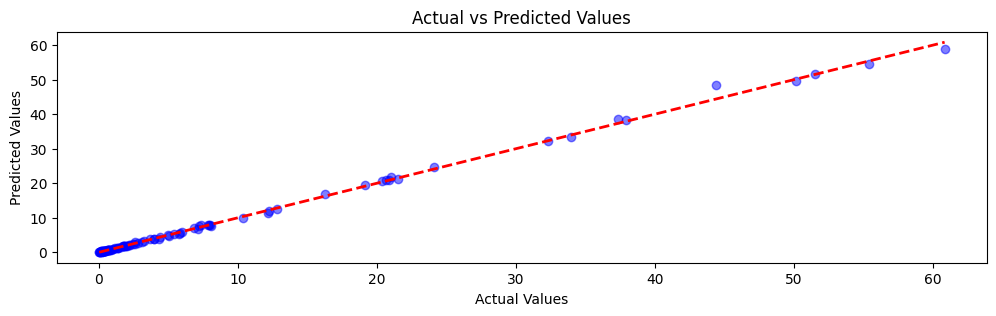

In [23]:
plt.figure(figsize=(12, 3))#Create a scatter plot figure with the specified size
#Scatter plot of predicted vs. actual values
plt.scatter(y_test, y_pred, color='blue', label='Predicted', alpha=0.5)
#Add a red dashed line representing actual vs. actual values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2, label='Actual')
plt.xlabel('Actual Values')#Set the x-axis label
plt.ylabel('Predicted Values')#Set the y-axis label
plt.title('Actual vs Predicted Values')#Display the legend
plt.show()#Show the plot

### CatBoostRegressor

In [24]:
#Define the CatBoostRegressor model
catboost_model = CatBoostRegressor()

In [25]:
#Specify the parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300]
}

In [26]:
# Create a grid search object
grid_search = GridSearchCV(catboost_model, param_grid, cv=5, scoring='neg_mean_squared_error')

In [27]:
# Fit the grid search to the training data
grid_search.fit(x_train, y_train)

0:	learn: 16.0785245	total: 139ms	remaining: 13.8s
1:	learn: 15.9625256	total: 141ms	remaining: 6.89s
2:	learn: 15.8581572	total: 142ms	remaining: 4.59s
3:	learn: 15.7382183	total: 143ms	remaining: 3.43s
4:	learn: 15.6430225	total: 144ms	remaining: 2.73s
5:	learn: 15.5423428	total: 145ms	remaining: 2.27s
6:	learn: 15.4216508	total: 146ms	remaining: 1.94s
7:	learn: 15.3029945	total: 147ms	remaining: 1.69s
8:	learn: 15.1841786	total: 148ms	remaining: 1.5s
9:	learn: 15.0681003	total: 149ms	remaining: 1.34s
10:	learn: 14.9425659	total: 150ms	remaining: 1.22s
11:	learn: 14.8312496	total: 151ms	remaining: 1.11s
12:	learn: 14.7316882	total: 152ms	remaining: 1.02s
13:	learn: 14.6335073	total: 154ms	remaining: 944ms
14:	learn: 14.5396884	total: 155ms	remaining: 876ms
15:	learn: 14.4417785	total: 156ms	remaining: 818ms
16:	learn: 14.3221849	total: 157ms	remaining: 766ms
17:	learn: 14.2280308	total: 158ms	remaining: 719ms
18:	learn: 14.1183450	total: 159ms	remaining: 678ms
19:	learn: 14.0234478	t

95:	learn: 8.2978597	total: 20.6ms	remaining: 22.3ms
96:	learn: 8.2383743	total: 20.9ms	remaining: 22.2ms
97:	learn: 8.1904071	total: 21.2ms	remaining: 22ms
98:	learn: 8.1325287	total: 21.4ms	remaining: 21.8ms
99:	learn: 8.0781405	total: 21.6ms	remaining: 21.6ms
100:	learn: 8.0230409	total: 21.9ms	remaining: 21.4ms
101:	learn: 7.9769663	total: 22.1ms	remaining: 21.2ms
102:	learn: 7.9206329	total: 22.3ms	remaining: 21ms
103:	learn: 7.8685020	total: 22.5ms	remaining: 20.8ms
104:	learn: 7.8113226	total: 22.8ms	remaining: 20.6ms
105:	learn: 7.7556219	total: 23ms	remaining: 20.4ms
106:	learn: 7.7058010	total: 23.2ms	remaining: 20.2ms
107:	learn: 7.6596840	total: 23.4ms	remaining: 19.9ms
108:	learn: 7.6099708	total: 23.6ms	remaining: 19.7ms
109:	learn: 7.5555674	total: 23.9ms	remaining: 19.5ms
110:	learn: 7.5050544	total: 24.1ms	remaining: 19.3ms
111:	learn: 7.4520090	total: 24.3ms	remaining: 19.1ms
112:	learn: 7.4015564	total: 24.5ms	remaining: 18.9ms
113:	learn: 7.3464625	total: 24.8ms	rem

26:	learn: 12.7484945	total: 6.07ms	remaining: 38.9ms
27:	learn: 12.6722557	total: 6.52ms	remaining: 40.1ms
28:	learn: 12.5843034	total: 6.72ms	remaining: 39.6ms
29:	learn: 12.4910345	total: 6.91ms	remaining: 39.2ms
30:	learn: 12.4133895	total: 7.11ms	remaining: 38.7ms
31:	learn: 12.3360979	total: 7.31ms	remaining: 38.4ms
32:	learn: 12.2398760	total: 7.51ms	remaining: 38ms
33:	learn: 12.1486381	total: 7.73ms	remaining: 37.7ms
34:	learn: 12.0691391	total: 7.93ms	remaining: 37.4ms
35:	learn: 11.9717713	total: 8.14ms	remaining: 37.1ms
36:	learn: 11.8995326	total: 8.34ms	remaining: 36.7ms
37:	learn: 11.8225378	total: 8.53ms	remaining: 36.4ms
38:	learn: 11.7446205	total: 8.73ms	remaining: 36ms
39:	learn: 11.6575270	total: 8.96ms	remaining: 35.8ms
40:	learn: 11.5726672	total: 9.17ms	remaining: 35.6ms
41:	learn: 11.5013527	total: 9.37ms	remaining: 35.3ms
42:	learn: 11.4308182	total: 9.58ms	remaining: 35ms
43:	learn: 11.3495506	total: 9.77ms	remaining: 34.6ms
44:	learn: 11.2730144	total: 9.96m

217:	learn: 3.7970046	total: 44.8ms	remaining: 16.9ms
218:	learn: 3.7734929	total: 45.2ms	remaining: 16.7ms
219:	learn: 3.7578836	total: 45.4ms	remaining: 16.5ms
220:	learn: 3.7335720	total: 45.5ms	remaining: 16.3ms
221:	learn: 3.7071554	total: 45.7ms	remaining: 16.1ms
222:	learn: 3.6905691	total: 45.9ms	remaining: 15.8ms
223:	learn: 3.6700393	total: 46.1ms	remaining: 15.6ms
224:	learn: 3.6429817	total: 46.3ms	remaining: 15.4ms
225:	learn: 3.6255735	total: 46.5ms	remaining: 15.2ms
226:	learn: 3.6050943	total: 46.7ms	remaining: 15ms
227:	learn: 3.5798947	total: 46.9ms	remaining: 14.8ms
228:	learn: 3.5563787	total: 47.1ms	remaining: 14.6ms
229:	learn: 3.5342044	total: 47.3ms	remaining: 14.4ms
230:	learn: 3.5151064	total: 47.7ms	remaining: 14.2ms
231:	learn: 3.4902938	total: 47.9ms	remaining: 14ms
232:	learn: 3.4682483	total: 48.1ms	remaining: 13.8ms
233:	learn: 3.4466917	total: 48.4ms	remaining: 13.6ms
234:	learn: 3.4235102	total: 48.8ms	remaining: 13.5ms
235:	learn: 3.3993673	total: 49m

158:	learn: 5.4809238	total: 37.8ms	remaining: 33.5ms
159:	learn: 5.4432671	total: 38.1ms	remaining: 33.3ms
160:	learn: 5.4002219	total: 38.3ms	remaining: 33.1ms
161:	learn: 5.3701025	total: 38.5ms	remaining: 32.8ms
162:	learn: 5.3346896	total: 38.7ms	remaining: 32.5ms
163:	learn: 5.2992068	total: 38.9ms	remaining: 32.3ms
164:	learn: 5.2637703	total: 39.2ms	remaining: 32.1ms
165:	learn: 5.2360137	total: 39.5ms	remaining: 31.9ms
166:	learn: 5.1985370	total: 39.7ms	remaining: 31.6ms
167:	learn: 5.1626579	total: 39.9ms	remaining: 31.4ms
168:	learn: 5.1225200	total: 40.1ms	remaining: 31.1ms
169:	learn: 5.0887724	total: 40.4ms	remaining: 30.9ms
170:	learn: 5.0489853	total: 40.6ms	remaining: 30.6ms
171:	learn: 5.0188001	total: 40.8ms	remaining: 30.4ms
172:	learn: 4.9860498	total: 41.1ms	remaining: 30.1ms
173:	learn: 4.9590617	total: 41.2ms	remaining: 29.9ms
174:	learn: 4.9326552	total: 41.4ms	remaining: 29.6ms
175:	learn: 4.9068013	total: 41.6ms	remaining: 29.3ms
176:	learn: 4.8758340	total:

75:	learn: 9.4003959	total: 18.5ms	remaining: 54.4ms
76:	learn: 9.3341635	total: 18.8ms	remaining: 54.4ms
77:	learn: 9.2708900	total: 19ms	remaining: 54ms
78:	learn: 9.2043717	total: 19.2ms	remaining: 53.6ms
79:	learn: 9.1479081	total: 19.4ms	remaining: 53.3ms
80:	learn: 9.0786688	total: 19.6ms	remaining: 53ms
81:	learn: 9.0081104	total: 19.8ms	remaining: 52.8ms
82:	learn: 8.9347927	total: 20.1ms	remaining: 52.5ms
83:	learn: 8.8692998	total: 20.4ms	remaining: 52.4ms
84:	learn: 8.8117041	total: 20.6ms	remaining: 52.2ms
85:	learn: 8.7538136	total: 20.9ms	remaining: 52ms
86:	learn: 8.6824945	total: 21.1ms	remaining: 51.7ms
87:	learn: 8.6303891	total: 21.6ms	remaining: 51.9ms
88:	learn: 8.5724445	total: 21.8ms	remaining: 51.7ms
89:	learn: 8.5212661	total: 22.1ms	remaining: 51.5ms
90:	learn: 8.4746325	total: 22.3ms	remaining: 51.3ms
91:	learn: 8.4154642	total: 22.6ms	remaining: 51.1ms
92:	learn: 8.3643128	total: 22.8ms	remaining: 50.8ms
93:	learn: 8.3178209	total: 23ms	remaining: 50.5ms
94:

0:	learn: 15.3502299	total: 535us	remaining: 53ms
1:	learn: 15.2570392	total: 963us	remaining: 47.2ms
2:	learn: 15.1374018	total: 1.23ms	remaining: 39.9ms
3:	learn: 15.0397136	total: 1.44ms	remaining: 34.6ms
4:	learn: 14.9388988	total: 1.66ms	remaining: 31.5ms
5:	learn: 14.8453539	total: 1.87ms	remaining: 29.3ms
6:	learn: 14.7435819	total: 2.08ms	remaining: 27.6ms
7:	learn: 14.6390187	total: 2.3ms	remaining: 26.5ms
8:	learn: 14.5456277	total: 2.56ms	remaining: 25.8ms
9:	learn: 14.4522857	total: 2.82ms	remaining: 25.4ms
10:	learn: 14.3493868	total: 3.05ms	remaining: 24.6ms
11:	learn: 14.2466272	total: 3.33ms	remaining: 24.4ms
12:	learn: 14.1554094	total: 3.59ms	remaining: 24.1ms
13:	learn: 14.0687031	total: 3.83ms	remaining: 23.6ms
14:	learn: 13.9792647	total: 4.08ms	remaining: 23.1ms
15:	learn: 13.8926208	total: 4.32ms	remaining: 22.7ms
16:	learn: 13.7996486	total: 4.57ms	remaining: 22.3ms
17:	learn: 13.7004818	total: 4.87ms	remaining: 22.2ms
18:	learn: 13.6002842	total: 5.12ms	remaini

0:	learn: 14.4525108	total: 578us	remaining: 115ms
1:	learn: 14.3644101	total: 1.14ms	remaining: 113ms
2:	learn: 14.2529770	total: 1.49ms	remaining: 97.8ms
3:	learn: 14.1598090	total: 1.8ms	remaining: 88.1ms
4:	learn: 14.0665067	total: 2.18ms	remaining: 85.1ms
5:	learn: 13.9610900	total: 2.56ms	remaining: 82.9ms
6:	learn: 13.8668953	total: 2.89ms	remaining: 79.7ms
7:	learn: 13.7716268	total: 3.17ms	remaining: 76ms
8:	learn: 13.6820586	total: 3.48ms	remaining: 73.9ms
9:	learn: 13.5923169	total: 3.88ms	remaining: 73.7ms
10:	learn: 13.4962424	total: 4.65ms	remaining: 79.9ms
11:	learn: 13.3959807	total: 5.84ms	remaining: 91.5ms
12:	learn: 13.3141641	total: 6.21ms	remaining: 89.3ms
13:	learn: 13.2337149	total: 6.49ms	remaining: 86.2ms
14:	learn: 13.1481124	total: 6.82ms	remaining: 84.1ms
15:	learn: 13.0588500	total: 7.08ms	remaining: 81.4ms
16:	learn: 12.9718437	total: 7.43ms	remaining: 80ms
17:	learn: 12.8722796	total: 7.83ms	remaining: 79.2ms
18:	learn: 12.7795576	total: 8.17ms	remaining:

0:	learn: 15.3502299	total: 379us	remaining: 75.5ms
1:	learn: 15.2570392	total: 889us	remaining: 88.1ms
2:	learn: 15.1374018	total: 1.12ms	remaining: 73.6ms
3:	learn: 15.0397136	total: 1.34ms	remaining: 65.7ms
4:	learn: 14.9388988	total: 1.64ms	remaining: 63.9ms
5:	learn: 14.8453539	total: 1.88ms	remaining: 60.7ms
6:	learn: 14.7435819	total: 2.12ms	remaining: 58.3ms
7:	learn: 14.6390187	total: 2.36ms	remaining: 56.7ms
8:	learn: 14.5456277	total: 2.6ms	remaining: 55.2ms
9:	learn: 14.4522857	total: 2.84ms	remaining: 53.9ms
10:	learn: 14.3493868	total: 3.09ms	remaining: 53.2ms
11:	learn: 14.2466272	total: 3.36ms	remaining: 52.6ms
12:	learn: 14.1554094	total: 3.6ms	remaining: 51.8ms
13:	learn: 14.0687031	total: 3.83ms	remaining: 50.9ms
14:	learn: 13.9792647	total: 4.08ms	remaining: 50.3ms
15:	learn: 13.8926208	total: 4.35ms	remaining: 50ms
16:	learn: 13.7996486	total: 4.62ms	remaining: 49.7ms
17:	learn: 13.7004818	total: 4.92ms	remaining: 49.7ms
18:	learn: 13.6002842	total: 5.21ms	remainin

139:	learn: 6.4349817	total: 36ms	remaining: 41.1ms
140:	learn: 6.3972298	total: 36.4ms	remaining: 41.1ms
141:	learn: 6.3657214	total: 36.7ms	remaining: 40.8ms
142:	learn: 6.3252886	total: 36.9ms	remaining: 40.5ms
143:	learn: 6.2800646	total: 37.2ms	remaining: 40.3ms
144:	learn: 6.2416758	total: 37.5ms	remaining: 40ms
145:	learn: 6.2003228	total: 37.7ms	remaining: 39.8ms
146:	learn: 6.1592876	total: 38ms	remaining: 39.5ms
147:	learn: 6.1203423	total: 38.3ms	remaining: 39.3ms
148:	learn: 6.0858953	total: 38.5ms	remaining: 39ms
149:	learn: 6.0577701	total: 38.7ms	remaining: 38.7ms
150:	learn: 6.0212401	total: 39ms	remaining: 38.5ms
151:	learn: 5.9849443	total: 39.2ms	remaining: 38.2ms
152:	learn: 5.9552627	total: 39.4ms	remaining: 37.9ms
153:	learn: 5.9270360	total: 39.7ms	remaining: 37.6ms
154:	learn: 5.8888736	total: 39.9ms	remaining: 37.3ms
155:	learn: 5.8529437	total: 40.1ms	remaining: 37.1ms
156:	learn: 5.8179834	total: 40.4ms	remaining: 36.8ms
157:	learn: 5.7879983	total: 40.6ms	re

33:	learn: 12.9642940	total: 9.76ms	remaining: 76.4ms
34:	learn: 12.8733005	total: 10.2ms	remaining: 77.2ms
35:	learn: 12.8025120	total: 10.5ms	remaining: 76.8ms
36:	learn: 12.7232874	total: 10.8ms	remaining: 76.6ms
37:	learn: 12.6296968	total: 11ms	remaining: 76ms
38:	learn: 12.5518362	total: 11.3ms	remaining: 75.6ms
39:	learn: 12.4641183	total: 11.6ms	remaining: 75.3ms
40:	learn: 12.3777497	total: 11.9ms	remaining: 75ms
41:	learn: 12.2842193	total: 12.1ms	remaining: 74.5ms
42:	learn: 12.2107884	total: 12.4ms	remaining: 73.9ms
43:	learn: 12.1350452	total: 12.6ms	remaining: 73.4ms
44:	learn: 12.0536429	total: 12.9ms	remaining: 73.3ms
45:	learn: 11.9699489	total: 13.2ms	remaining: 72.8ms
46:	learn: 11.8826201	total: 13.5ms	remaining: 72.4ms
47:	learn: 11.8066114	total: 13.7ms	remaining: 71.8ms
48:	learn: 11.7185415	total: 13.9ms	remaining: 71.2ms
49:	learn: 11.6380668	total: 14.1ms	remaining: 70.6ms
50:	learn: 11.5495906	total: 14.3ms	remaining: 70ms
51:	learn: 11.4754109	total: 14.6ms	

0:	learn: 15.7294466	total: 396us	remaining: 119ms
1:	learn: 15.6338700	total: 863us	remaining: 129ms
2:	learn: 15.5099482	total: 1.1ms	remaining: 109ms
3:	learn: 15.4099682	total: 1.33ms	remaining: 98.3ms
4:	learn: 15.3064989	total: 1.56ms	remaining: 92.3ms
5:	learn: 15.2151308	total: 1.83ms	remaining: 89.9ms
6:	learn: 15.1307021	total: 2.15ms	remaining: 90ms
7:	learn: 15.0228908	total: 2.43ms	remaining: 88.7ms
8:	learn: 14.9267159	total: 2.7ms	remaining: 87.4ms
9:	learn: 14.8290959	total: 2.95ms	remaining: 85.6ms
10:	learn: 14.7218818	total: 3.21ms	remaining: 84.3ms
11:	learn: 14.6140931	total: 3.51ms	remaining: 84.3ms
12:	learn: 14.5214813	total: 3.78ms	remaining: 83.4ms
13:	learn: 14.4328401	total: 4.11ms	remaining: 83.9ms
14:	learn: 14.3379511	total: 4.38ms	remaining: 83.3ms
15:	learn: 14.2509142	total: 4.63ms	remaining: 82.3ms
16:	learn: 14.1550054	total: 4.96ms	remaining: 82.6ms
17:	learn: 14.0687847	total: 5.21ms	remaining: 81.6ms
18:	learn: 13.9759652	total: 5.55ms	remaining: 

91:	learn: 8.2256187	total: 25.7ms	remaining: 2.23ms
92:	learn: 8.1661920	total: 26ms	remaining: 1.96ms
93:	learn: 8.1204825	total: 26.3ms	remaining: 1.68ms
94:	learn: 8.0713368	total: 26.7ms	remaining: 1.4ms
95:	learn: 8.0202456	total: 27ms	remaining: 1.12ms
96:	learn: 7.9674369	total: 27.3ms	remaining: 844us
97:	learn: 7.9149582	total: 27.6ms	remaining: 563us
98:	learn: 7.8685042	total: 27.9ms	remaining: 281us
99:	learn: 7.8258516	total: 28.2ms	remaining: 0us
0:	learn: 16.2747656	total: 345us	remaining: 34.2ms
1:	learn: 16.1544531	total: 610us	remaining: 29.9ms
2:	learn: 16.0514365	total: 860us	remaining: 27.8ms
3:	learn: 15.9276867	total: 1.11ms	remaining: 26.7ms
4:	learn: 15.8263036	total: 1.41ms	remaining: 26.8ms
5:	learn: 15.7180082	total: 1.67ms	remaining: 26.2ms
6:	learn: 15.6173282	total: 1.91ms	remaining: 25.4ms
7:	learn: 15.5133710	total: 2.23ms	remaining: 25.7ms
8:	learn: 15.3991182	total: 2.52ms	remaining: 25.4ms
9:	learn: 15.2949900	total: 2.78ms	remaining: 25ms
10:	learn

1:	learn: 15.9825710	total: 2.09ms	remaining: 207ms
2:	learn: 15.8832785	total: 2.64ms	remaining: 173ms
3:	learn: 15.7681970	total: 2.98ms	remaining: 146ms
4:	learn: 15.6705370	total: 3.29ms	remaining: 128ms
5:	learn: 15.5643615	total: 3.62ms	remaining: 117ms
6:	learn: 15.4744751	total: 3.95ms	remaining: 109ms
7:	learn: 15.3729617	total: 4.32ms	remaining: 104ms
8:	learn: 15.2614415	total: 4.71ms	remaining: 100ms
9:	learn: 15.1607890	total: 5.04ms	remaining: 95.7ms
10:	learn: 15.0762876	total: 5.36ms	remaining: 92ms
11:	learn: 14.9699579	total: 5.77ms	remaining: 90.5ms
12:	learn: 14.8629786	total: 6.19ms	remaining: 89ms
13:	learn: 14.7849295	total: 6.68ms	remaining: 88.7ms
14:	learn: 14.6766709	total: 7.27ms	remaining: 89.7ms
15:	learn: 14.5778594	total: 7.57ms	remaining: 87ms
16:	learn: 14.4938393	total: 7.94ms	remaining: 85.5ms
17:	learn: 14.4080279	total: 8.22ms	remaining: 83.1ms
18:	learn: 14.2956990	total: 8.52ms	remaining: 81.2ms
19:	learn: 14.2176220	total: 8.82ms	remaining: 79.4

0:	learn: 16.2747656	total: 405us	remaining: 80.7ms
1:	learn: 16.1544531	total: 930us	remaining: 92.1ms
2:	learn: 16.0514365	total: 1.2ms	remaining: 78.7ms
3:	learn: 15.9276867	total: 1.47ms	remaining: 72.1ms
4:	learn: 15.8263036	total: 1.73ms	remaining: 67.6ms
5:	learn: 15.7180082	total: 1.98ms	remaining: 64.2ms
6:	learn: 15.6173282	total: 2.23ms	remaining: 61.6ms
7:	learn: 15.5133710	total: 2.48ms	remaining: 59.6ms
8:	learn: 15.3991182	total: 2.74ms	remaining: 58.1ms
9:	learn: 15.2949900	total: 2.99ms	remaining: 56.8ms
10:	learn: 15.2072899	total: 3.24ms	remaining: 55.7ms
11:	learn: 15.1145712	total: 3.49ms	remaining: 54.7ms
12:	learn: 15.0064622	total: 3.76ms	remaining: 54ms
13:	learn: 14.9235139	total: 4.02ms	remaining: 53.4ms
14:	learn: 14.8140071	total: 4.27ms	remaining: 52.7ms
15:	learn: 14.7117243	total: 4.53ms	remaining: 52.1ms
16:	learn: 14.6105114	total: 4.79ms	remaining: 51.6ms
17:	learn: 14.5214209	total: 5.04ms	remaining: 50.9ms
18:	learn: 14.4076511	total: 5.38ms	remaini

79:	learn: 9.5389622	total: 24.6ms	remaining: 36.9ms
80:	learn: 9.4771035	total: 26ms	remaining: 38.3ms
81:	learn: 9.4039350	total: 26.4ms	remaining: 38ms
82:	learn: 9.3520963	total: 26.9ms	remaining: 38ms
83:	learn: 9.2997878	total: 27.3ms	remaining: 37.7ms
84:	learn: 9.2382475	total: 27.7ms	remaining: 37.5ms
85:	learn: 9.1706890	total: 28ms	remaining: 37.2ms
86:	learn: 9.1037567	total: 28.4ms	remaining: 36.9ms
87:	learn: 9.0413814	total: 28.7ms	remaining: 36.5ms
88:	learn: 8.9702678	total: 29.1ms	remaining: 36.3ms
89:	learn: 8.9146795	total: 29.5ms	remaining: 36.1ms
90:	learn: 8.8481943	total: 29.9ms	remaining: 35.8ms
91:	learn: 8.7902517	total: 30.3ms	remaining: 35.5ms
92:	learn: 8.7363677	total: 30.6ms	remaining: 35.2ms
93:	learn: 8.6861062	total: 31ms	remaining: 35ms
94:	learn: 8.6310286	total: 31.4ms	remaining: 34.7ms
95:	learn: 8.5732715	total: 31.6ms	remaining: 34.2ms
96:	learn: 8.5131901	total: 31.9ms	remaining: 33.9ms
97:	learn: 8.4505479	total: 32.3ms	remaining: 33.6ms
98:	l

273:	learn: 3.1863306	total: 89.7ms	remaining: 8.51ms
274:	learn: 3.1703915	total: 90.5ms	remaining: 8.23ms
275:	learn: 3.1531838	total: 91ms	remaining: 7.91ms
276:	learn: 3.1359751	total: 91.4ms	remaining: 7.59ms
277:	learn: 3.1198303	total: 91.8ms	remaining: 7.26ms
278:	learn: 3.1037105	total: 92.2ms	remaining: 6.94ms
279:	learn: 3.0848747	total: 92.5ms	remaining: 6.6ms
280:	learn: 3.0667887	total: 92.8ms	remaining: 6.28ms
281:	learn: 3.0491238	total: 93.1ms	remaining: 5.95ms
282:	learn: 3.0337256	total: 93.6ms	remaining: 5.62ms
283:	learn: 3.0168578	total: 93.9ms	remaining: 5.29ms
284:	learn: 3.0025489	total: 94.3ms	remaining: 4.96ms
285:	learn: 2.9867695	total: 94.6ms	remaining: 4.63ms
286:	learn: 2.9708890	total: 94.9ms	remaining: 4.3ms
287:	learn: 2.9575715	total: 95.2ms	remaining: 3.97ms
288:	learn: 2.9438293	total: 95.5ms	remaining: 3.63ms
289:	learn: 2.9295928	total: 95.8ms	remaining: 3.3ms
290:	learn: 2.9172870	total: 96.1ms	remaining: 2.97ms
291:	learn: 2.9018001	total: 96.4

101:	learn: 8.4877178	total: 29.1ms	remaining: 56.5ms
102:	learn: 8.4342686	total: 29.5ms	remaining: 56.5ms
103:	learn: 8.3761132	total: 29.8ms	remaining: 56.2ms
104:	learn: 8.3344825	total: 30.1ms	remaining: 56ms
105:	learn: 8.2766723	total: 30.4ms	remaining: 55.7ms
106:	learn: 8.2345935	total: 30.7ms	remaining: 55.4ms
107:	learn: 8.1800060	total: 31ms	remaining: 55.1ms
108:	learn: 8.1266712	total: 31.3ms	remaining: 54.8ms
109:	learn: 8.0821323	total: 31.6ms	remaining: 54.5ms
110:	learn: 8.0346497	total: 31.9ms	remaining: 54.3ms
111:	learn: 7.9845330	total: 32.2ms	remaining: 54.1ms
112:	learn: 7.9390560	total: 32.5ms	remaining: 53.8ms
113:	learn: 7.8814479	total: 32.8ms	remaining: 53.5ms
114:	learn: 7.8292989	total: 33.1ms	remaining: 53.2ms
115:	learn: 7.8023651	total: 33.5ms	remaining: 53.2ms
116:	learn: 7.7561090	total: 33.9ms	remaining: 53ms
117:	learn: 7.7095084	total: 34.2ms	remaining: 52.7ms
118:	learn: 7.6664855	total: 34.5ms	remaining: 52.5ms
119:	learn: 7.6281462	total: 34.8m

0:	learn: 15.7424917	total: 674us	remaining: 202ms
1:	learn: 15.6278087	total: 1.32ms	remaining: 197ms
2:	learn: 15.5284785	total: 1.93ms	remaining: 191ms
3:	learn: 15.4173008	total: 3.03ms	remaining: 224ms
4:	learn: 15.3171907	total: 4.07ms	remaining: 240ms
5:	learn: 15.2104257	total: 4.93ms	remaining: 242ms
6:	learn: 15.1133303	total: 5.38ms	remaining: 225ms
7:	learn: 15.0112868	total: 5.86ms	remaining: 214ms
8:	learn: 14.9042948	total: 6.26ms	remaining: 202ms
9:	learn: 14.8028761	total: 6.68ms	remaining: 194ms
10:	learn: 14.7178280	total: 7.28ms	remaining: 191ms
11:	learn: 14.6264662	total: 7.85ms	remaining: 188ms
12:	learn: 14.5225111	total: 8.41ms	remaining: 186ms
13:	learn: 14.4424460	total: 8.94ms	remaining: 183ms
14:	learn: 14.3382293	total: 9.43ms	remaining: 179ms
15:	learn: 14.2392347	total: 9.9ms	remaining: 176ms
16:	learn: 14.1417328	total: 10.3ms	remaining: 171ms
17:	learn: 14.0529794	total: 10.6ms	remaining: 167ms
18:	learn: 13.9431622	total: 11ms	remaining: 163ms
19:	lea

52:	learn: 1.2092139	total: 12ms	remaining: 10.7ms
53:	learn: 1.1885213	total: 12.4ms	remaining: 10.6ms
54:	learn: 1.1609515	total: 12.6ms	remaining: 10.3ms
55:	learn: 1.1402042	total: 12.8ms	remaining: 10.1ms
56:	learn: 1.1219135	total: 13.1ms	remaining: 9.9ms
57:	learn: 1.1058663	total: 13.5ms	remaining: 9.76ms
58:	learn: 1.0845325	total: 13.8ms	remaining: 9.6ms
59:	learn: 1.0719281	total: 14.2ms	remaining: 9.46ms
60:	learn: 1.0616362	total: 14.5ms	remaining: 9.28ms
61:	learn: 1.0439792	total: 14.7ms	remaining: 9.03ms
62:	learn: 1.0270498	total: 15ms	remaining: 8.81ms
63:	learn: 1.0139524	total: 15.2ms	remaining: 8.56ms
64:	learn: 1.0000215	total: 15.4ms	remaining: 8.32ms
65:	learn: 0.9931452	total: 15.7ms	remaining: 8.07ms
66:	learn: 0.9766152	total: 15.9ms	remaining: 7.81ms
67:	learn: 0.9681451	total: 16.1ms	remaining: 7.56ms
68:	learn: 0.9564511	total: 16.3ms	remaining: 7.32ms
69:	learn: 0.9488692	total: 16.5ms	remaining: 7.07ms
70:	learn: 0.9421707	total: 16.7ms	remaining: 6.83ms

68:	learn: 0.9793854	total: 15.1ms	remaining: 28.7ms
69:	learn: 0.9730507	total: 15.5ms	remaining: 28.8ms
70:	learn: 0.9654353	total: 15.7ms	remaining: 28.5ms
71:	learn: 0.9585764	total: 15.9ms	remaining: 28.2ms
72:	learn: 0.9461190	total: 16.1ms	remaining: 28ms
73:	learn: 0.9346604	total: 16.3ms	remaining: 27.8ms
74:	learn: 0.9200851	total: 16.6ms	remaining: 27.6ms
75:	learn: 0.9137966	total: 16.8ms	remaining: 27.4ms
76:	learn: 0.9078578	total: 17ms	remaining: 27.1ms
77:	learn: 0.8999762	total: 17.2ms	remaining: 26.9ms
78:	learn: 0.8939665	total: 17.4ms	remaining: 26.7ms
79:	learn: 0.8785320	total: 17.6ms	remaining: 26.4ms
80:	learn: 0.8737055	total: 17.8ms	remaining: 26.2ms
81:	learn: 0.8628834	total: 18.1ms	remaining: 26ms
82:	learn: 0.8542096	total: 18.3ms	remaining: 25.8ms
83:	learn: 0.8501394	total: 18.6ms	remaining: 25.6ms
84:	learn: 0.8376067	total: 18.8ms	remaining: 25.5ms
85:	learn: 0.8264599	total: 19.1ms	remaining: 25.3ms
86:	learn: 0.8161822	total: 19.3ms	remaining: 25ms
8

0:	learn: 15.3048753	total: 469us	remaining: 93.5ms
1:	learn: 14.2030536	total: 1.06ms	remaining: 105ms
2:	learn: 13.0715511	total: 1.39ms	remaining: 91.1ms
3:	learn: 12.1135274	total: 1.62ms	remaining: 79.3ms
4:	learn: 11.4006206	total: 1.9ms	remaining: 73.9ms
5:	learn: 10.7252510	total: 2.15ms	remaining: 69.4ms
6:	learn: 9.9610099	total: 2.41ms	remaining: 66.5ms
7:	learn: 9.2545178	total: 2.68ms	remaining: 64.3ms
8:	learn: 8.6096081	total: 2.96ms	remaining: 62.8ms
9:	learn: 8.0012049	total: 3.28ms	remaining: 62.3ms
10:	learn: 7.3541534	total: 3.53ms	remaining: 60.6ms
11:	learn: 6.8562042	total: 3.83ms	remaining: 60ms
12:	learn: 6.4629926	total: 4.11ms	remaining: 59.1ms
13:	learn: 5.9528288	total: 4.36ms	remaining: 57.9ms
14:	learn: 5.6997451	total: 4.61ms	remaining: 56.9ms
15:	learn: 5.2821370	total: 4.84ms	remaining: 55.7ms
16:	learn: 4.8872995	total: 5.08ms	remaining: 54.7ms
17:	learn: 4.6239560	total: 5.5ms	remaining: 55.6ms
18:	learn: 4.3599387	total: 5.89ms	remaining: 56.1ms
19:

102:	learn: 0.7122243	total: 32.7ms	remaining: 30.8ms
103:	learn: 0.7052930	total: 33.1ms	remaining: 30.5ms
104:	learn: 0.7020088	total: 33.4ms	remaining: 30.2ms
105:	learn: 0.6962031	total: 33.7ms	remaining: 29.9ms
106:	learn: 0.6924973	total: 34ms	remaining: 29.5ms
107:	learn: 0.6885314	total: 34.2ms	remaining: 29.2ms
108:	learn: 0.6861887	total: 34.5ms	remaining: 28.8ms
109:	learn: 0.6842687	total: 34.8ms	remaining: 28.5ms
110:	learn: 0.6825574	total: 35.1ms	remaining: 28.1ms
111:	learn: 0.6767128	total: 35.4ms	remaining: 27.8ms
112:	learn: 0.6700873	total: 35.7ms	remaining: 27.5ms
113:	learn: 0.6683252	total: 35.9ms	remaining: 27.1ms
114:	learn: 0.6614246	total: 36.1ms	remaining: 26.7ms
115:	learn: 0.6588694	total: 36.5ms	remaining: 26.4ms
116:	learn: 0.6573295	total: 36.8ms	remaining: 26.1ms
117:	learn: 0.6550577	total: 37ms	remaining: 25.7ms
118:	learn: 0.6503329	total: 37.4ms	remaining: 25.4ms
119:	learn: 0.6447644	total: 37.6ms	remaining: 25.1ms
120:	learn: 0.6387711	total: 37.

46:	learn: 1.3670570	total: 9.77ms	remaining: 52.6ms
47:	learn: 1.3323245	total: 10.3ms	remaining: 54ms
48:	learn: 1.3032977	total: 10.5ms	remaining: 53.8ms
49:	learn: 1.2789469	total: 10.7ms	remaining: 53.4ms
50:	learn: 1.2541949	total: 10.9ms	remaining: 53.1ms
51:	learn: 1.2271653	total: 11.1ms	remaining: 52.8ms
52:	learn: 1.2065837	total: 11.3ms	remaining: 52.6ms
53:	learn: 1.1806012	total: 11.5ms	remaining: 52.2ms
54:	learn: 1.1562952	total: 11.7ms	remaining: 51.9ms
55:	learn: 1.1382207	total: 11.9ms	remaining: 51.8ms
56:	learn: 1.1249726	total: 12.1ms	remaining: 51.6ms
57:	learn: 1.1083264	total: 12.3ms	remaining: 51.5ms
58:	learn: 1.0991232	total: 12.6ms	remaining: 51.4ms
59:	learn: 1.0892842	total: 12.8ms	remaining: 51.2ms
60:	learn: 1.0700274	total: 13ms	remaining: 51ms
61:	learn: 1.0525134	total: 13.2ms	remaining: 50.8ms
62:	learn: 1.0400284	total: 13.5ms	remaining: 50.7ms
63:	learn: 1.0308958	total: 13.7ms	remaining: 50.4ms
64:	learn: 1.0229414	total: 13.9ms	remaining: 50.1ms

94:	learn: 0.7595172	total: 20.9ms	remaining: 45ms
95:	learn: 0.7493177	total: 21.3ms	remaining: 45.2ms
96:	learn: 0.7468997	total: 21.5ms	remaining: 44.9ms
97:	learn: 0.7446086	total: 21.7ms	remaining: 44.7ms
98:	learn: 0.7372834	total: 21.9ms	remaining: 44.4ms
99:	learn: 0.7282788	total: 22.1ms	remaining: 44.1ms
100:	learn: 0.7257745	total: 22.2ms	remaining: 43.8ms
101:	learn: 0.7224384	total: 22.4ms	remaining: 43.6ms
102:	learn: 0.7204527	total: 22.6ms	remaining: 43.3ms
103:	learn: 0.7139958	total: 22.8ms	remaining: 43ms
104:	learn: 0.7120903	total: 23.1ms	remaining: 42.8ms
105:	learn: 0.7102821	total: 23.3ms	remaining: 42.7ms
106:	learn: 0.6987109	total: 23.5ms	remaining: 42.5ms
107:	learn: 0.6935228	total: 23.8ms	remaining: 42.2ms
108:	learn: 0.6879901	total: 23.9ms	remaining: 42ms
109:	learn: 0.6826107	total: 24.1ms	remaining: 41.7ms
110:	learn: 0.6765543	total: 24.3ms	remaining: 41.4ms
111:	learn: 0.6734046	total: 24.5ms	remaining: 41.2ms
112:	learn: 0.6683769	total: 24.8ms	rema

50:	learn: 1.2648684	total: 12.9ms	remaining: 63.2ms
51:	learn: 1.2368310	total: 13.3ms	remaining: 63.6ms
52:	learn: 1.2133655	total: 13.6ms	remaining: 63.4ms
53:	learn: 1.1824628	total: 13.9ms	remaining: 63.3ms
54:	learn: 1.1521557	total: 14.1ms	remaining: 62.8ms
55:	learn: 1.1305863	total: 14.3ms	remaining: 62.5ms
56:	learn: 1.1069165	total: 14.6ms	remaining: 62.2ms
57:	learn: 1.0893007	total: 14.9ms	remaining: 62.2ms
58:	learn: 1.0782855	total: 15.1ms	remaining: 61.6ms
59:	learn: 1.0580048	total: 15.4ms	remaining: 61.5ms
60:	learn: 1.0484706	total: 15.6ms	remaining: 61ms
61:	learn: 1.0278135	total: 15.8ms	remaining: 60.7ms
62:	learn: 1.0185705	total: 16ms	remaining: 60.2ms
63:	learn: 1.0099709	total: 16.2ms	remaining: 59.8ms
64:	learn: 1.0019632	total: 16.4ms	remaining: 59.3ms
65:	learn: 0.9945005	total: 16.7ms	remaining: 59.1ms
66:	learn: 0.9775299	total: 16.9ms	remaining: 58.7ms
67:	learn: 0.9712828	total: 17.1ms	remaining: 58.4ms
68:	learn: 0.9653942	total: 17.4ms	remaining: 58.2

34:	learn: 1.9019478	total: 10.6ms	remaining: 19.7ms
35:	learn: 1.8231821	total: 11.1ms	remaining: 19.8ms
36:	learn: 1.7488865	total: 11.5ms	remaining: 19.6ms
37:	learn: 1.6950286	total: 12.1ms	remaining: 19.8ms
38:	learn: 1.6315268	total: 12.4ms	remaining: 19.4ms
39:	learn: 1.5630762	total: 12.7ms	remaining: 19ms
40:	learn: 1.5060720	total: 12.9ms	remaining: 18.6ms
41:	learn: 1.4499941	total: 13.2ms	remaining: 18.2ms
42:	learn: 1.4050557	total: 13.4ms	remaining: 17.8ms
43:	learn: 1.3613729	total: 13.6ms	remaining: 17.4ms
44:	learn: 1.3163308	total: 13.9ms	remaining: 17ms
45:	learn: 1.2710134	total: 14.3ms	remaining: 16.7ms
46:	learn: 1.2310848	total: 14.6ms	remaining: 16.4ms
47:	learn: 1.1923145	total: 14.9ms	remaining: 16.2ms
48:	learn: 1.1615699	total: 15.2ms	remaining: 15.8ms
49:	learn: 1.1377264	total: 15.5ms	remaining: 15.5ms
50:	learn: 1.1070721	total: 15.8ms	remaining: 15.1ms
51:	learn: 1.0719668	total: 16.1ms	remaining: 14.8ms
52:	learn: 1.0460654	total: 16.3ms	remaining: 14.5

0:	learn: 15.2725342	total: 343us	remaining: 68.3ms
1:	learn: 14.3556510	total: 716us	remaining: 70.9ms
2:	learn: 13.2411238	total: 999us	remaining: 65.6ms
3:	learn: 12.4113685	total: 1.27ms	remaining: 62.5ms
4:	learn: 11.6161844	total: 1.55ms	remaining: 60.5ms
5:	learn: 10.8245634	total: 1.81ms	remaining: 58.6ms
6:	learn: 10.0939190	total: 2.07ms	remaining: 57.1ms
7:	learn: 9.4195357	total: 2.34ms	remaining: 56.2ms
8:	learn: 8.8581496	total: 2.59ms	remaining: 55ms
9:	learn: 8.3329500	total: 2.83ms	remaining: 53.7ms
10:	learn: 7.7196527	total: 3.12ms	remaining: 53.7ms
11:	learn: 7.2214112	total: 3.41ms	remaining: 53.4ms
12:	learn: 6.7658812	total: 3.69ms	remaining: 53.1ms
13:	learn: 6.3347756	total: 3.98ms	remaining: 52.8ms
14:	learn: 5.8960251	total: 4.25ms	remaining: 52.4ms
15:	learn: 5.5785719	total: 4.49ms	remaining: 51.7ms
16:	learn: 5.2989730	total: 4.74ms	remaining: 51ms
17:	learn: 4.9999221	total: 4.99ms	remaining: 50.4ms
18:	learn: 4.7097161	total: 5.21ms	remaining: 49.7ms
19:

85:	learn: 0.6513494	total: 20.9ms	remaining: 27.7ms
86:	learn: 0.6431984	total: 21.3ms	remaining: 27.7ms
87:	learn: 0.6386317	total: 21.6ms	remaining: 27.4ms
88:	learn: 0.6288211	total: 21.8ms	remaining: 27.2ms
89:	learn: 0.6235021	total: 22ms	remaining: 26.9ms
90:	learn: 0.6192306	total: 22.3ms	remaining: 26.7ms
91:	learn: 0.6152099	total: 22.5ms	remaining: 26.4ms
92:	learn: 0.6114232	total: 22.8ms	remaining: 26.2ms
93:	learn: 0.6078552	total: 23ms	remaining: 25.9ms
94:	learn: 0.6044917	total: 23.2ms	remaining: 25.7ms
95:	learn: 0.5955336	total: 23.5ms	remaining: 25.4ms
96:	learn: 0.5912980	total: 23.7ms	remaining: 25.2ms
97:	learn: 0.5882411	total: 24ms	remaining: 24.9ms
98:	learn: 0.5853619	total: 24.2ms	remaining: 24.7ms
99:	learn: 0.5759416	total: 24.4ms	remaining: 24.4ms
100:	learn: 0.5732735	total: 24.7ms	remaining: 24.2ms
101:	learn: 0.5625840	total: 24.9ms	remaining: 23.9ms
102:	learn: 0.5581108	total: 25.2ms	remaining: 23.7ms
103:	learn: 0.5556432	total: 25.4ms	remaining: 23

0:	learn: 15.2725342	total: 375us	remaining: 112ms
1:	learn: 14.3556510	total: 818us	remaining: 122ms
2:	learn: 13.2411238	total: 1.06ms	remaining: 105ms
3:	learn: 12.4113685	total: 1.29ms	remaining: 95.7ms
4:	learn: 11.6161844	total: 1.53ms	remaining: 90.3ms
5:	learn: 10.8245634	total: 1.77ms	remaining: 86.9ms
6:	learn: 10.0939190	total: 2.02ms	remaining: 84.5ms
7:	learn: 9.4195357	total: 2.28ms	remaining: 83.3ms
8:	learn: 8.8581496	total: 2.54ms	remaining: 82.1ms
9:	learn: 8.3329500	total: 13.1ms	remaining: 380ms
10:	learn: 7.7196527	total: 13.4ms	remaining: 351ms
11:	learn: 7.2214112	total: 13.6ms	remaining: 326ms
12:	learn: 6.7658812	total: 13.8ms	remaining: 305ms
13:	learn: 6.3347756	total: 14ms	remaining: 287ms
14:	learn: 5.8960251	total: 14.3ms	remaining: 271ms
15:	learn: 5.5785719	total: 14.5ms	remaining: 257ms
16:	learn: 5.2989730	total: 14.7ms	remaining: 245ms
17:	learn: 4.9999221	total: 14.9ms	remaining: 234ms
18:	learn: 4.7097161	total: 15.2ms	remaining: 224ms
19:	learn: 4.

293:	learn: 0.1873752	total: 71ms	remaining: 1.45ms
294:	learn: 0.1865607	total: 71.7ms	remaining: 1.21ms
295:	learn: 0.1858610	total: 71.9ms	remaining: 972us
296:	learn: 0.1851192	total: 72.2ms	remaining: 729us
297:	learn: 0.1844855	total: 72.5ms	remaining: 486us
298:	learn: 0.1841849	total: 72.9ms	remaining: 243us
299:	learn: 0.1835203	total: 73.2ms	remaining: 0us
0:	learn: 15.4181676	total: 373us	remaining: 112ms
1:	learn: 14.4765870	total: 629us	remaining: 93.8ms
2:	learn: 13.3029465	total: 868us	remaining: 86ms
3:	learn: 12.4655514	total: 1.09ms	remaining: 80.9ms
4:	learn: 11.6420622	total: 1.36ms	remaining: 80.1ms
5:	learn: 10.7671058	total: 1.59ms	remaining: 78.1ms
6:	learn: 10.0324496	total: 1.83ms	remaining: 76.6ms
7:	learn: 9.3555161	total: 2.05ms	remaining: 74.9ms
8:	learn: 8.7961831	total: 2.27ms	remaining: 73.3ms
9:	learn: 8.2633944	total: 2.49ms	remaining: 72.2ms
10:	learn: 7.7865000	total: 2.72ms	remaining: 71.5ms
11:	learn: 7.3084145	total: 2.95ms	remaining: 70.8ms
12:	

172:	learn: 0.2918522	total: 48.6ms	remaining: 35.7ms
173:	learn: 0.2896539	total: 49.2ms	remaining: 35.6ms
174:	learn: 0.2866240	total: 49.7ms	remaining: 35.5ms
175:	learn: 0.2845104	total: 50.1ms	remaining: 35.3ms
176:	learn: 0.2827723	total: 50.4ms	remaining: 35.1ms
177:	learn: 0.2810522	total: 51ms	remaining: 34.9ms
178:	learn: 0.2796027	total: 51.6ms	remaining: 34.9ms
179:	learn: 0.2764597	total: 62.4ms	remaining: 41.6ms
180:	learn: 0.2737429	total: 62.7ms	remaining: 41.2ms
181:	learn: 0.2723911	total: 63ms	remaining: 40.9ms
182:	learn: 0.2710770	total: 63.4ms	remaining: 40.5ms
183:	learn: 0.2690884	total: 63.7ms	remaining: 40.2ms
184:	learn: 0.2679293	total: 64.1ms	remaining: 39.8ms
185:	learn: 0.2659542	total: 64.4ms	remaining: 39.5ms
186:	learn: 0.2634274	total: 64.7ms	remaining: 39.1ms
187:	learn: 0.2620435	total: 65.1ms	remaining: 38.8ms
188:	learn: 0.2604545	total: 65.4ms	remaining: 38.4ms
189:	learn: 0.2591679	total: 65.6ms	remaining: 38ms
190:	learn: 0.2578288	total: 65.9m

0:	learn: 15.3888734	total: 407us	remaining: 40.4ms
1:	learn: 14.2614581	total: 902us	remaining: 44.2ms
2:	learn: 13.4004618	total: 1.22ms	remaining: 39.5ms
3:	learn: 12.4348702	total: 1.54ms	remaining: 37ms
4:	learn: 11.6949248	total: 1.87ms	remaining: 35.6ms
5:	learn: 10.9385020	total: 2.25ms	remaining: 35.2ms
6:	learn: 10.1969234	total: 2.59ms	remaining: 34.4ms
7:	learn: 9.5690974	total: 3.12ms	remaining: 35.9ms
8:	learn: 8.9169311	total: 3.42ms	remaining: 34.5ms
9:	learn: 8.2995630	total: 3.71ms	remaining: 33.4ms
10:	learn: 7.8879678	total: 4.01ms	remaining: 32.5ms
11:	learn: 7.3273901	total: 4.29ms	remaining: 31.5ms
12:	learn: 6.8213051	total: 4.58ms	remaining: 30.7ms
13:	learn: 6.5113159	total: 4.87ms	remaining: 29.9ms
14:	learn: 6.0968350	total: 5.16ms	remaining: 29.3ms
15:	learn: 5.7462996	total: 5.45ms	remaining: 28.6ms
16:	learn: 5.3721079	total: 5.75ms	remaining: 28.1ms
17:	learn: 5.0049153	total: 6.01ms	remaining: 27.4ms
18:	learn: 4.6922183	total: 6.3ms	remaining: 26.9ms
1

0:	learn: 14.7040942	total: 460us	remaining: 45.6ms
1:	learn: 13.6578388	total: 1ms	remaining: 49.2ms
2:	learn: 12.8292463	total: 1.32ms	remaining: 42.6ms
3:	learn: 11.8881430	total: 1.64ms	remaining: 39.4ms
4:	learn: 11.1902683	total: 1.94ms	remaining: 36.8ms
5:	learn: 10.4727431	total: 2.21ms	remaining: 34.7ms
6:	learn: 9.8533268	total: 2.56ms	remaining: 34.1ms
7:	learn: 9.2852920	total: 2.85ms	remaining: 32.8ms
8:	learn: 8.7327156	total: 3.16ms	remaining: 32ms
9:	learn: 8.1968031	total: 3.44ms	remaining: 31ms
10:	learn: 7.7606401	total: 3.72ms	remaining: 30.1ms
11:	learn: 7.3870580	total: 4.08ms	remaining: 29.9ms
12:	learn: 7.0657267	total: 4.35ms	remaining: 29.1ms
13:	learn: 6.6825160	total: 4.64ms	remaining: 28.5ms
14:	learn: 6.3052498	total: 4.95ms	remaining: 28.1ms
15:	learn: 5.9207965	total: 5.26ms	remaining: 27.6ms
16:	learn: 5.5677091	total: 5.6ms	remaining: 27.4ms
17:	learn: 5.1831633	total: 5.94ms	remaining: 27.1ms
18:	learn: 4.9398043	total: 6.26ms	remaining: 26.7ms
19:	le

0:	learn: 13.9237361	total: 425us	remaining: 84.6ms
1:	learn: 12.9403684	total: 875us	remaining: 86.7ms
2:	learn: 12.1901983	total: 1.25ms	remaining: 82.4ms
3:	learn: 11.3220816	total: 1.61ms	remaining: 79ms
4:	learn: 10.6340776	total: 1.97ms	remaining: 76.7ms
5:	learn: 9.9608601	total: 2.43ms	remaining: 78.4ms
6:	learn: 9.3950640	total: 2.83ms	remaining: 78ms
7:	learn: 8.8519020	total: 3.17ms	remaining: 76ms
8:	learn: 8.2613683	total: 3.48ms	remaining: 74ms
9:	learn: 7.7789393	total: 3.81ms	remaining: 72.4ms
10:	learn: 7.4158953	total: 4.16ms	remaining: 71.4ms
11:	learn: 6.9663913	total: 4.5ms	remaining: 70.5ms
12:	learn: 6.5054012	total: 4.79ms	remaining: 68.8ms
13:	learn: 6.1194220	total: 5.1ms	remaining: 67.8ms
14:	learn: 5.7554400	total: 5.4ms	remaining: 66.7ms
15:	learn: 5.4518106	total: 5.69ms	remaining: 65.4ms
16:	learn: 5.1384868	total: 6ms	remaining: 64.6ms
17:	learn: 4.8130406	total: 6.22ms	remaining: 62.9ms
18:	learn: 4.5024571	total: 6.57ms	remaining: 62.6ms
19:	learn: 4.3

9:	learn: 8.1968031	total: 3.53ms	remaining: 67ms
10:	learn: 7.7606401	total: 4ms	remaining: 68.7ms
11:	learn: 7.3870580	total: 4.32ms	remaining: 67.7ms
12:	learn: 7.0657267	total: 4.68ms	remaining: 67.4ms
13:	learn: 6.6825160	total: 5.04ms	remaining: 67ms
14:	learn: 6.3052498	total: 5.39ms	remaining: 66.5ms
15:	learn: 5.9207965	total: 5.77ms	remaining: 66.4ms
16:	learn: 5.5677091	total: 6.1ms	remaining: 65.7ms
17:	learn: 5.1831633	total: 6.5ms	remaining: 65.8ms
18:	learn: 4.9398043	total: 6.82ms	remaining: 64.9ms
19:	learn: 4.6547573	total: 7.2ms	remaining: 64.8ms
20:	learn: 4.3733768	total: 7.54ms	remaining: 64.2ms
21:	learn: 4.1529851	total: 7.83ms	remaining: 63.4ms
22:	learn: 3.9426935	total: 8.14ms	remaining: 62.7ms
23:	learn: 3.7463125	total: 8.42ms	remaining: 61.8ms
24:	learn: 3.5968133	total: 8.66ms	remaining: 60.6ms
25:	learn: 3.3472611	total: 8.97ms	remaining: 60ms
26:	learn: 3.1679317	total: 9.23ms	remaining: 59.2ms
27:	learn: 3.0112332	total: 9.55ms	remaining: 58.7ms
28:	le

0:	learn: 15.3888734	total: 447us	remaining: 134ms
1:	learn: 14.2614581	total: 902us	remaining: 135ms
2:	learn: 13.4004618	total: 1.21ms	remaining: 120ms
3:	learn: 12.4348702	total: 1.55ms	remaining: 115ms
4:	learn: 11.6949248	total: 1.91ms	remaining: 113ms
5:	learn: 10.9385020	total: 2.23ms	remaining: 110ms
6:	learn: 10.1969234	total: 2.58ms	remaining: 108ms
7:	learn: 9.5690974	total: 2.89ms	remaining: 105ms
8:	learn: 8.9169311	total: 3.21ms	remaining: 104ms
9:	learn: 8.2995630	total: 3.52ms	remaining: 102ms
10:	learn: 7.8879678	total: 3.84ms	remaining: 101ms
11:	learn: 7.3273901	total: 4.15ms	remaining: 99.6ms
12:	learn: 6.8213051	total: 4.46ms	remaining: 98.5ms
13:	learn: 6.5113159	total: 4.79ms	remaining: 97.8ms
14:	learn: 6.0968350	total: 5.13ms	remaining: 97.6ms
15:	learn: 5.7462996	total: 5.49ms	remaining: 97.4ms
16:	learn: 5.3721079	total: 5.82ms	remaining: 96.9ms
17:	learn: 5.0049153	total: 6.08ms	remaining: 95.2ms
18:	learn: 4.6922183	total: 6.38ms	remaining: 94.4ms
19:	learn

110:	learn: 0.4081136	total: 32.8ms	remaining: 55.9ms
111:	learn: 0.4054589	total: 33.3ms	remaining: 55.9ms
112:	learn: 0.4003975	total: 33.6ms	remaining: 55.7ms
113:	learn: 0.3969597	total: 34ms	remaining: 55.5ms
114:	learn: 0.3914016	total: 34.4ms	remaining: 55.4ms
115:	learn: 0.3881605	total: 34.7ms	remaining: 55.1ms
116:	learn: 0.3821206	total: 35.1ms	remaining: 54.9ms
117:	learn: 0.3776131	total: 35.4ms	remaining: 54.6ms
118:	learn: 0.3746821	total: 35.7ms	remaining: 54.4ms
119:	learn: 0.3725841	total: 36.1ms	remaining: 54.1ms
120:	learn: 0.3699368	total: 36.4ms	remaining: 53.8ms
121:	learn: 0.3659155	total: 36.7ms	remaining: 53.5ms
122:	learn: 0.3634846	total: 37ms	remaining: 53.2ms
123:	learn: 0.3599056	total: 37.3ms	remaining: 52.9ms
124:	learn: 0.3562898	total: 37.6ms	remaining: 52.7ms
125:	learn: 0.3530916	total: 37.9ms	remaining: 52.4ms
126:	learn: 0.3505161	total: 38.3ms	remaining: 52.1ms
127:	learn: 0.3471534	total: 38.6ms	remaining: 51.9ms
128:	learn: 0.3432246	total: 39m

286:	learn: 0.1552226	total: 89.5ms	remaining: 4.05ms
287:	learn: 0.1542322	total: 89.8ms	remaining: 3.74ms
288:	learn: 0.1539706	total: 90.1ms	remaining: 3.43ms
289:	learn: 0.1526136	total: 90.4ms	remaining: 3.12ms
290:	learn: 0.1520795	total: 90.7ms	remaining: 2.8ms
291:	learn: 0.1515881	total: 91ms	remaining: 2.49ms
292:	learn: 0.1511101	total: 91.3ms	remaining: 2.18ms
293:	learn: 0.1503439	total: 91.5ms	remaining: 1.87ms
294:	learn: 0.1498633	total: 91.8ms	remaining: 1.56ms
295:	learn: 0.1494604	total: 92.1ms	remaining: 1.25ms
296:	learn: 0.1482465	total: 92.4ms	remaining: 933us
297:	learn: 0.1478234	total: 92.8ms	remaining: 622us
298:	learn: 0.1469312	total: 93.1ms	remaining: 311us
299:	learn: 0.1466065	total: 93.5ms	remaining: 0us
0:	learn: 14.7040942	total: 392us	remaining: 117ms
1:	learn: 13.6578388	total: 679us	remaining: 101ms
2:	learn: 12.8292463	total: 994us	remaining: 98.5ms
3:	learn: 11.8881430	total: 1.27ms	remaining: 93.9ms
4:	learn: 11.1902683	total: 1.57ms	remaining: 

121:	learn: 0.4443331	total: 37.7ms	remaining: 55ms
122:	learn: 0.4389041	total: 38ms	remaining: 54.8ms
123:	learn: 0.4333864	total: 38.3ms	remaining: 54.4ms
124:	learn: 0.4293151	total: 38.6ms	remaining: 54.1ms
125:	learn: 0.4241918	total: 39ms	remaining: 53.8ms
126:	learn: 0.4203541	total: 39.3ms	remaining: 53.6ms
127:	learn: 0.4157681	total: 39.6ms	remaining: 53.3ms
128:	learn: 0.4103477	total: 40ms	remaining: 53ms
129:	learn: 0.4070912	total: 40.2ms	remaining: 52.6ms
130:	learn: 0.4045889	total: 40.5ms	remaining: 52.3ms
131:	learn: 0.3997744	total: 40.8ms	remaining: 51.9ms
132:	learn: 0.3958184	total: 41.1ms	remaining: 51.6ms
133:	learn: 0.3923322	total: 41.4ms	remaining: 51.3ms
134:	learn: 0.3869581	total: 41.6ms	remaining: 50.9ms
135:	learn: 0.3830617	total: 42ms	remaining: 50.6ms
136:	learn: 0.3790810	total: 42.2ms	remaining: 50.3ms
137:	learn: 0.3739357	total: 42.5ms	remaining: 50ms
138:	learn: 0.3695735	total: 42.9ms	remaining: 49.6ms
139:	learn: 0.3664195	total: 43.1ms	remain

75:	learn: 0.5759893	total: 14.1ms	remaining: 4.46ms
76:	learn: 0.5681635	total: 14.6ms	remaining: 4.36ms
77:	learn: 0.5579747	total: 14.8ms	remaining: 4.18ms
78:	learn: 0.5558053	total: 15ms	remaining: 3.99ms
79:	learn: 0.5530143	total: 15.2ms	remaining: 3.81ms
80:	learn: 0.5495221	total: 15.4ms	remaining: 3.62ms
81:	learn: 0.5401672	total: 15.7ms	remaining: 3.44ms
82:	learn: 0.5332955	total: 15.9ms	remaining: 3.25ms
83:	learn: 0.5238261	total: 16.1ms	remaining: 3.06ms
84:	learn: 0.5155847	total: 16.3ms	remaining: 2.87ms
85:	learn: 0.5044343	total: 16.5ms	remaining: 2.68ms
86:	learn: 0.4995569	total: 16.7ms	remaining: 2.49ms
87:	learn: 0.4964426	total: 16.9ms	remaining: 2.3ms
88:	learn: 0.4907883	total: 17.1ms	remaining: 2.11ms
89:	learn: 0.4863957	total: 17.3ms	remaining: 1.92ms
90:	learn: 0.4808695	total: 17.4ms	remaining: 1.73ms
91:	learn: 0.4773139	total: 17.7ms	remaining: 1.53ms
92:	learn: 0.4701945	total: 17.9ms	remaining: 1.34ms
93:	learn: 0.4686504	total: 18.1ms	remaining: 1.1

17:	learn: 2.1393213	total: 4.43ms	remaining: 44.8ms
18:	learn: 1.9972204	total: 4.76ms	remaining: 45.4ms
19:	learn: 1.8652582	total: 4.97ms	remaining: 44.7ms
20:	learn: 1.7748397	total: 5.19ms	remaining: 44.3ms
21:	learn: 1.6974396	total: 5.41ms	remaining: 43.8ms
22:	learn: 1.6446493	total: 5.65ms	remaining: 43.5ms
23:	learn: 1.5607525	total: 5.88ms	remaining: 43.1ms
24:	learn: 1.4999526	total: 6.1ms	remaining: 42.7ms
25:	learn: 1.4365814	total: 6.31ms	remaining: 42.2ms
26:	learn: 1.3938853	total: 6.5ms	remaining: 41.7ms
27:	learn: 1.3400297	total: 6.69ms	remaining: 41.1ms
28:	learn: 1.3006039	total: 6.87ms	remaining: 40.5ms
29:	learn: 1.2656988	total: 7.05ms	remaining: 39.9ms
30:	learn: 1.2531072	total: 7.23ms	remaining: 39.4ms
31:	learn: 1.2283006	total: 7.4ms	remaining: 38.9ms
32:	learn: 1.2018608	total: 7.58ms	remaining: 38.4ms
33:	learn: 1.1841089	total: 7.76ms	remaining: 37.9ms
34:	learn: 1.1490503	total: 7.95ms	remaining: 37.5ms
35:	learn: 1.1339138	total: 8.13ms	remaining: 37m

0:	learn: 13.8187839	total: 264us	remaining: 52.6ms
1:	learn: 11.8688394	total: 705us	remaining: 69.8ms
2:	learn: 10.5757158	total: 897us	remaining: 58.9ms
3:	learn: 9.1587099	total: 1.08ms	remaining: 53.1ms
4:	learn: 8.0001692	total: 1.26ms	remaining: 49.3ms
5:	learn: 7.3918779	total: 1.47ms	remaining: 47.4ms
6:	learn: 6.5625873	total: 1.64ms	remaining: 45.3ms
7:	learn: 5.7962396	total: 1.84ms	remaining: 44.2ms
8:	learn: 5.2578925	total: 2.02ms	remaining: 42.9ms
9:	learn: 4.5762615	total: 2.23ms	remaining: 42.5ms
10:	learn: 3.9725709	total: 2.42ms	remaining: 41.7ms
11:	learn: 3.5377545	total: 2.62ms	remaining: 41ms
12:	learn: 3.2057880	total: 2.79ms	remaining: 40.2ms
13:	learn: 2.9116064	total: 2.98ms	remaining: 39.6ms
14:	learn: 2.6711521	total: 3.16ms	remaining: 39ms
15:	learn: 2.5093350	total: 3.35ms	remaining: 38.5ms
16:	learn: 2.2999460	total: 3.53ms	remaining: 38ms
17:	learn: 2.1930753	total: 3.71ms	remaining: 37.5ms
18:	learn: 2.0422930	total: 3.92ms	remaining: 37.3ms
19:	learn

120:	learn: 0.3921416	total: 25.2ms	remaining: 37.3ms
121:	learn: 0.3886921	total: 25.9ms	remaining: 37.8ms
122:	learn: 0.3854844	total: 26.1ms	remaining: 37.5ms
123:	learn: 0.3822704	total: 26.3ms	remaining: 37.3ms
124:	learn: 0.3801412	total: 26.5ms	remaining: 37.1ms
125:	learn: 0.3778817	total: 26.7ms	remaining: 36.9ms
126:	learn: 0.3747822	total: 27ms	remaining: 36.7ms
127:	learn: 0.3704629	total: 27.2ms	remaining: 36.6ms
128:	learn: 0.3692496	total: 27.5ms	remaining: 36.4ms
129:	learn: 0.3668492	total: 27.7ms	remaining: 36.3ms
130:	learn: 0.3647921	total: 27.9ms	remaining: 36.1ms
131:	learn: 0.3631841	total: 28.2ms	remaining: 35.9ms
132:	learn: 0.3614325	total: 28.4ms	remaining: 35.6ms
133:	learn: 0.3567235	total: 28.6ms	remaining: 35.4ms
134:	learn: 0.3515123	total: 28.8ms	remaining: 35.2ms
135:	learn: 0.3470204	total: 29ms	remaining: 35ms
136:	learn: 0.3454886	total: 29.2ms	remaining: 34.7ms
137:	learn: 0.3441449	total: 29.4ms	remaining: 34.5ms
138:	learn: 0.3417079	total: 29.6m

114:	learn: 0.3735995	total: 23.8ms	remaining: 38.3ms
115:	learn: 0.3711529	total: 24.4ms	remaining: 38.6ms
116:	learn: 0.3674557	total: 24.6ms	remaining: 38.4ms
117:	learn: 0.3620898	total: 24.8ms	remaining: 38.3ms
118:	learn: 0.3604909	total: 25.1ms	remaining: 38.2ms
119:	learn: 0.3579348	total: 25.4ms	remaining: 38.1ms
120:	learn: 0.3547586	total: 25.6ms	remaining: 37.9ms
121:	learn: 0.3511918	total: 25.8ms	remaining: 37.7ms
122:	learn: 0.3481859	total: 26.1ms	remaining: 37.5ms
123:	learn: 0.3471319	total: 26.3ms	remaining: 37.3ms
124:	learn: 0.3458765	total: 26.5ms	remaining: 37.1ms
125:	learn: 0.3405546	total: 26.7ms	remaining: 36.9ms
126:	learn: 0.3376863	total: 26.9ms	remaining: 36.7ms
127:	learn: 0.3331600	total: 27.1ms	remaining: 36.5ms
128:	learn: 0.3309240	total: 27.4ms	remaining: 36.3ms
129:	learn: 0.3291152	total: 27.6ms	remaining: 36ms
130:	learn: 0.3261751	total: 27.8ms	remaining: 35.8ms
131:	learn: 0.3216207	total: 27.9ms	remaining: 35.6ms
132:	learn: 0.3189245	total: 2

83:	learn: 0.3209875	total: 23.6ms	remaining: 4.49ms
84:	learn: 0.3159272	total: 24ms	remaining: 4.23ms
85:	learn: 0.3121222	total: 24.3ms	remaining: 3.95ms
86:	learn: 0.3032386	total: 24.6ms	remaining: 3.67ms
87:	learn: 0.2989383	total: 24.9ms	remaining: 3.39ms
88:	learn: 0.2950431	total: 25.2ms	remaining: 3.11ms
89:	learn: 0.2927594	total: 25.4ms	remaining: 2.83ms
90:	learn: 0.2889506	total: 25.7ms	remaining: 2.54ms
91:	learn: 0.2827068	total: 25.9ms	remaining: 2.25ms
92:	learn: 0.2799853	total: 26.2ms	remaining: 1.97ms
93:	learn: 0.2768000	total: 26.5ms	remaining: 1.69ms
94:	learn: 0.2733793	total: 26.8ms	remaining: 1.41ms
95:	learn: 0.2706570	total: 27ms	remaining: 1.12ms
96:	learn: 0.2673965	total: 27.3ms	remaining: 843us
97:	learn: 0.2631948	total: 27.5ms	remaining: 562us
98:	learn: 0.2586941	total: 27.8ms	remaining: 280us
99:	learn: 0.2568965	total: 28.1ms	remaining: 0us
0:	learn: 13.0854647	total: 324us	remaining: 32.1ms
1:	learn: 11.5131075	total: 818us	remaining: 40.1ms
2:	le

32:	learn: 0.8783855	total: 9.16ms	remaining: 18.6ms
33:	learn: 0.8513100	total: 9.55ms	remaining: 18.5ms
34:	learn: 0.8144771	total: 9.8ms	remaining: 18.2ms
35:	learn: 0.7943084	total: 10ms	remaining: 17.8ms
36:	learn: 0.7825432	total: 10.3ms	remaining: 17.5ms
37:	learn: 0.7665664	total: 10.5ms	remaining: 17.1ms
38:	learn: 0.7474068	total: 10.7ms	remaining: 16.8ms
39:	learn: 0.7231265	total: 11ms	remaining: 16.4ms
40:	learn: 0.7159076	total: 11.2ms	remaining: 16.1ms
41:	learn: 0.6951521	total: 11.4ms	remaining: 15.8ms
42:	learn: 0.6761563	total: 11.7ms	remaining: 15.4ms
43:	learn: 0.6607337	total: 11.9ms	remaining: 15.1ms
44:	learn: 0.6469696	total: 12.1ms	remaining: 14.8ms
45:	learn: 0.6391773	total: 12.3ms	remaining: 14.5ms
46:	learn: 0.6279286	total: 12.6ms	remaining: 14.2ms
47:	learn: 0.6178217	total: 12.8ms	remaining: 13.9ms
48:	learn: 0.6091307	total: 13ms	remaining: 13.6ms
49:	learn: 0.6028088	total: 13.3ms	remaining: 13.3ms
50:	learn: 0.5951738	total: 13.5ms	remaining: 13ms
51

0:	learn: 14.4975249	total: 307us	remaining: 61.2ms
1:	learn: 12.7524597	total: 729us	remaining: 72.2ms
2:	learn: 10.6586989	total: 1.01ms	remaining: 66.4ms
3:	learn: 9.3500008	total: 1.28ms	remaining: 62.6ms
4:	learn: 8.1508121	total: 1.5ms	remaining: 58.7ms
5:	learn: 7.0263099	total: 1.72ms	remaining: 55.5ms
6:	learn: 6.2265496	total: 1.92ms	remaining: 53ms
7:	learn: 5.4559258	total: 2.22ms	remaining: 53.3ms
8:	learn: 4.9349785	total: 2.48ms	remaining: 52.7ms
9:	learn: 4.4668283	total: 2.73ms	remaining: 52ms
10:	learn: 3.9939146	total: 2.97ms	remaining: 51.1ms
11:	learn: 3.4553226	total: 3.23ms	remaining: 50.6ms
12:	learn: 3.1341401	total: 3.56ms	remaining: 51.3ms
13:	learn: 2.7897977	total: 3.83ms	remaining: 50.9ms
14:	learn: 2.5407796	total: 4.08ms	remaining: 50.3ms
15:	learn: 2.3257444	total: 4.31ms	remaining: 49.6ms
16:	learn: 2.1217041	total: 4.54ms	remaining: 48.9ms
17:	learn: 1.9404844	total: 4.82ms	remaining: 48.7ms
18:	learn: 1.8154187	total: 5.15ms	remaining: 49.1ms
19:	lea

30:	learn: 0.9266908	total: 34.2ms	remaining: 186ms
31:	learn: 0.9036368	total: 36ms	remaining: 189ms
32:	learn: 0.8783855	total: 37.1ms	remaining: 188ms
33:	learn: 0.8513100	total: 38.3ms	remaining: 187ms
34:	learn: 0.8144771	total: 39.5ms	remaining: 186ms
35:	learn: 0.7943084	total: 40.5ms	remaining: 184ms
36:	learn: 0.7825432	total: 41.5ms	remaining: 183ms
37:	learn: 0.7665664	total: 42.6ms	remaining: 182ms
38:	learn: 0.7474068	total: 43.5ms	remaining: 180ms
39:	learn: 0.7231265	total: 44.5ms	remaining: 178ms
40:	learn: 0.7159076	total: 45.5ms	remaining: 176ms
41:	learn: 0.6951521	total: 46.4ms	remaining: 175ms
42:	learn: 0.6761563	total: 47.5ms	remaining: 173ms
43:	learn: 0.6607337	total: 48.9ms	remaining: 173ms
44:	learn: 0.6469696	total: 50.1ms	remaining: 173ms
45:	learn: 0.6391773	total: 51.2ms	remaining: 171ms
46:	learn: 0.6279286	total: 52.6ms	remaining: 171ms
47:	learn: 0.6178217	total: 53.8ms	remaining: 170ms
48:	learn: 0.6091307	total: 54.8ms	remaining: 169ms
49:	learn: 0.6

79:	learn: 0.3412624	total: 19.6ms	remaining: 53.9ms
80:	learn: 0.3372072	total: 20ms	remaining: 54ms
81:	learn: 0.3317658	total: 20.2ms	remaining: 53.8ms
82:	learn: 0.3271201	total: 20.5ms	remaining: 53.5ms
83:	learn: 0.3209875	total: 20.7ms	remaining: 53.2ms
84:	learn: 0.3159272	total: 20.9ms	remaining: 52.9ms
85:	learn: 0.3121222	total: 21.1ms	remaining: 52.6ms
86:	learn: 0.3032386	total: 21.4ms	remaining: 52.3ms
87:	learn: 0.2989383	total: 21.6ms	remaining: 52ms
88:	learn: 0.2950431	total: 21.8ms	remaining: 51.8ms
89:	learn: 0.2927594	total: 22.1ms	remaining: 51.5ms
90:	learn: 0.2889506	total: 22.3ms	remaining: 51.1ms
91:	learn: 0.2827068	total: 22.5ms	remaining: 50.9ms
92:	learn: 0.2799853	total: 22.7ms	remaining: 50.5ms
93:	learn: 0.2768000	total: 22.9ms	remaining: 50.2ms
94:	learn: 0.2733793	total: 23.1ms	remaining: 49.9ms
95:	learn: 0.2706570	total: 23.4ms	remaining: 49.7ms
96:	learn: 0.2673965	total: 23.6ms	remaining: 49.4ms
97:	learn: 0.2631948	total: 23.9ms	remaining: 49.2ms

0:	learn: 14.4975249	total: 349us	remaining: 104ms
1:	learn: 12.7524597	total: 806us	remaining: 120ms
2:	learn: 10.6586989	total: 1.04ms	remaining: 103ms
3:	learn: 9.3500008	total: 1.27ms	remaining: 93.9ms
4:	learn: 8.1508121	total: 1.49ms	remaining: 88ms
5:	learn: 7.0263099	total: 1.76ms	remaining: 86.2ms
6:	learn: 6.2265496	total: 2.02ms	remaining: 84.8ms
7:	learn: 5.4559258	total: 2.27ms	remaining: 82.8ms
8:	learn: 4.9349785	total: 2.53ms	remaining: 81.7ms
9:	learn: 4.4668283	total: 2.77ms	remaining: 80.2ms
10:	learn: 3.9939146	total: 3.05ms	remaining: 80.2ms
11:	learn: 3.4553226	total: 3.34ms	remaining: 80.1ms
12:	learn: 3.1341401	total: 3.7ms	remaining: 81.6ms
13:	learn: 2.7897977	total: 4.24ms	remaining: 86.7ms
14:	learn: 2.5407796	total: 4.54ms	remaining: 86.3ms
15:	learn: 2.3257444	total: 4.87ms	remaining: 86.4ms
16:	learn: 2.1217041	total: 5.14ms	remaining: 85.6ms
17:	learn: 1.9404844	total: 5.47ms	remaining: 85.8ms
18:	learn: 1.8154187	total: 5.75ms	remaining: 85.1ms
19:	lear

0:	learn: 14.0560754	total: 1.15ms	remaining: 343ms
1:	learn: 12.3974473	total: 2.41ms	remaining: 359ms
2:	learn: 10.3832658	total: 3.34ms	remaining: 330ms
3:	learn: 8.6949081	total: 4.29ms	remaining: 317ms
4:	learn: 7.6365755	total: 5.25ms	remaining: 310ms
5:	learn: 6.6474378	total: 6.14ms	remaining: 301ms
6:	learn: 5.8951517	total: 6.99ms	remaining: 293ms
7:	learn: 5.2031954	total: 8.02ms	remaining: 293ms
8:	learn: 4.7473125	total: 8.94ms	remaining: 289ms
9:	learn: 4.1948643	total: 9.83ms	remaining: 285ms
10:	learn: 3.7541069	total: 10.9ms	remaining: 285ms
11:	learn: 3.2611669	total: 11.8ms	remaining: 282ms
12:	learn: 2.9498466	total: 12.6ms	remaining: 279ms
13:	learn: 2.7351712	total: 13.4ms	remaining: 274ms
14:	learn: 2.5195765	total: 14.2ms	remaining: 271ms
15:	learn: 2.3315304	total: 15.2ms	remaining: 269ms
16:	learn: 2.0763327	total: 16.2ms	remaining: 270ms
17:	learn: 1.8926308	total: 17.1ms	remaining: 268ms
18:	learn: 1.7715945	total: 18.1ms	remaining: 267ms
19:	learn: 1.610656

224:	learn: 0.1041063	total: 156ms	remaining: 52ms
225:	learn: 0.1036724	total: 157ms	remaining: 51.4ms
226:	learn: 0.1030970	total: 157ms	remaining: 50.6ms
227:	learn: 0.1021768	total: 158ms	remaining: 49.8ms
228:	learn: 0.1014239	total: 158ms	remaining: 49ms
229:	learn: 0.1010766	total: 159ms	remaining: 48.3ms
230:	learn: 0.1006534	total: 159ms	remaining: 47.5ms
231:	learn: 0.0993010	total: 160ms	remaining: 46.8ms
232:	learn: 0.0984631	total: 160ms	remaining: 46ms
233:	learn: 0.0980753	total: 160ms	remaining: 45.2ms
234:	learn: 0.0977265	total: 161ms	remaining: 44.4ms
235:	learn: 0.0971909	total: 161ms	remaining: 43.6ms
236:	learn: 0.0971049	total: 161ms	remaining: 42.9ms
237:	learn: 0.0968137	total: 162ms	remaining: 42.1ms
238:	learn: 0.0960982	total: 162ms	remaining: 41.3ms
239:	learn: 0.0956172	total: 162ms	remaining: 40.6ms
240:	learn: 0.0952690	total: 163ms	remaining: 39.8ms
241:	learn: 0.0947289	total: 163ms	remaining: 39.1ms
242:	learn: 0.0943284	total: 163ms	remaining: 38.3ms

95:	learn: 0.3043872	total: 38.6ms	remaining: 1.61ms
96:	learn: 0.3018848	total: 39.2ms	remaining: 1.21ms
97:	learn: 0.2993595	total: 39.7ms	remaining: 810us
98:	learn: 0.2964702	total: 40.1ms	remaining: 405us
99:	learn: 0.2925542	total: 40.5ms	remaining: 0us
0:	learn: 13.9862489	total: 451us	remaining: 44.7ms
1:	learn: 12.0846973	total: 771us	remaining: 37.8ms
2:	learn: 10.6668348	total: 1.08ms	remaining: 34.9ms
3:	learn: 9.1442596	total: 1.37ms	remaining: 32.9ms
4:	learn: 8.1574508	total: 1.67ms	remaining: 31.8ms
5:	learn: 7.1514235	total: 1.98ms	remaining: 31ms
6:	learn: 6.3091971	total: 2.3ms	remaining: 30.5ms
7:	learn: 5.5410493	total: 2.57ms	remaining: 29.5ms
8:	learn: 4.8308480	total: 2.83ms	remaining: 28.7ms
9:	learn: 4.2327674	total: 3.1ms	remaining: 27.9ms
10:	learn: 3.8884029	total: 3.45ms	remaining: 27.9ms
11:	learn: 3.4871788	total: 3.75ms	remaining: 27.5ms
12:	learn: 3.0683205	total: 4.06ms	remaining: 27.2ms
13:	learn: 2.7489183	total: 4.33ms	remaining: 26.6ms
14:	learn: 

177:	learn: 0.1075454	total: 49.9ms	remaining: 6.17ms
178:	learn: 0.1060843	total: 50.6ms	remaining: 5.93ms
179:	learn: 0.1040588	total: 50.9ms	remaining: 5.65ms
180:	learn: 0.1032004	total: 51.2ms	remaining: 5.37ms
181:	learn: 0.1026342	total: 51.5ms	remaining: 5.1ms
182:	learn: 0.1017851	total: 51.9ms	remaining: 4.82ms
183:	learn: 0.1004876	total: 52.2ms	remaining: 4.54ms
184:	learn: 0.0987804	total: 52.4ms	remaining: 4.25ms
185:	learn: 0.0978140	total: 52.7ms	remaining: 3.97ms
186:	learn: 0.0973464	total: 53.1ms	remaining: 3.69ms
187:	learn: 0.0957840	total: 53.4ms	remaining: 3.4ms
188:	learn: 0.0948917	total: 53.6ms	remaining: 3.12ms
189:	learn: 0.0939196	total: 53.9ms	remaining: 2.84ms
190:	learn: 0.0936623	total: 54.2ms	remaining: 2.55ms
191:	learn: 0.0932829	total: 54.4ms	remaining: 2.27ms
192:	learn: 0.0924330	total: 54.8ms	remaining: 1.99ms
193:	learn: 0.0919988	total: 55.1ms	remaining: 1.7ms
194:	learn: 0.0911690	total: 55.4ms	remaining: 1.42ms
195:	learn: 0.0902285	total: 55

99:	learn: 0.2925542	total: 66.9ms	remaining: 66.9ms
100:	learn: 0.2904703	total: 69.3ms	remaining: 67.9ms
101:	learn: 0.2853912	total: 70.8ms	remaining: 68ms
102:	learn: 0.2836399	total: 72.4ms	remaining: 68.2ms
103:	learn: 0.2802829	total: 73.8ms	remaining: 68.1ms
104:	learn: 0.2763137	total: 75.3ms	remaining: 68.1ms
105:	learn: 0.2712036	total: 77.1ms	remaining: 68.4ms
106:	learn: 0.2670924	total: 78.6ms	remaining: 68.3ms
107:	learn: 0.2639804	total: 80.1ms	remaining: 68.2ms
108:	learn: 0.2613525	total: 81.5ms	remaining: 68ms
109:	learn: 0.2580477	total: 83.1ms	remaining: 68ms
110:	learn: 0.2541930	total: 84.5ms	remaining: 67.8ms
111:	learn: 0.2493865	total: 85.9ms	remaining: 67.5ms
112:	learn: 0.2456206	total: 87.4ms	remaining: 67.3ms
113:	learn: 0.2430153	total: 88.9ms	remaining: 67.1ms
114:	learn: 0.2406478	total: 90.5ms	remaining: 66.9ms
115:	learn: 0.2391550	total: 91.5ms	remaining: 66.3ms
116:	learn: 0.2362659	total: 92.4ms	remaining: 65.6ms
117:	learn: 0.2337113	total: 93.3ms

0:	learn: 14.3106645	total: 358us	remaining: 71.4ms
1:	learn: 12.3524543	total: 830us	remaining: 82.2ms
2:	learn: 10.8751056	total: 1.13ms	remaining: 73.9ms
3:	learn: 9.3421408	total: 1.42ms	remaining: 69.6ms
4:	learn: 8.3731113	total: 1.69ms	remaining: 65.9ms
5:	learn: 7.4119506	total: 2.01ms	remaining: 65ms
6:	learn: 6.5024188	total: 2.29ms	remaining: 63.2ms
7:	learn: 5.7324441	total: 2.57ms	remaining: 61.8ms
8:	learn: 5.0491783	total: 2.79ms	remaining: 59.3ms
9:	learn: 4.4468078	total: 3.08ms	remaining: 58.5ms
10:	learn: 4.0283869	total: 3.39ms	remaining: 58.3ms
11:	learn: 3.5777180	total: 3.71ms	remaining: 58.1ms
12:	learn: 3.2684975	total: 4.08ms	remaining: 58.7ms
13:	learn: 2.9256000	total: 4.4ms	remaining: 58.5ms
14:	learn: 2.6462234	total: 4.72ms	remaining: 58.2ms
15:	learn: 2.4399062	total: 5.03ms	remaining: 57.8ms
16:	learn: 2.1819838	total: 5.32ms	remaining: 57.3ms
17:	learn: 1.9553923	total: 5.59ms	remaining: 56.6ms
18:	learn: 1.8019511	total: 5.87ms	remaining: 55.9ms
19:	l

0:	learn: 13.3328282	total: 346us	remaining: 104ms
1:	learn: 11.4795082	total: 804us	remaining: 120ms
2:	learn: 10.1905406	total: 1.1ms	remaining: 109ms
3:	learn: 8.7494295	total: 1.43ms	remaining: 106ms
4:	learn: 7.7438719	total: 1.74ms	remaining: 103ms
5:	learn: 6.7784528	total: 2.05ms	remaining: 100ms
6:	learn: 5.9719950	total: 2.33ms	remaining: 97.6ms
7:	learn: 5.3083919	total: 2.63ms	remaining: 96.2ms
8:	learn: 4.8045901	total: 2.94ms	remaining: 95.1ms
9:	learn: 4.3092414	total: 3.22ms	remaining: 93.4ms
10:	learn: 3.8995445	total: 3.5ms	remaining: 92ms
11:	learn: 3.4519807	total: 3.82ms	remaining: 91.6ms
12:	learn: 3.1476887	total: 4.18ms	remaining: 92.4ms
13:	learn: 2.8995597	total: 4.48ms	remaining: 91.5ms
14:	learn: 2.6462940	total: 4.8ms	remaining: 91.2ms
15:	learn: 2.3986315	total: 5.11ms	remaining: 90.7ms
16:	learn: 2.1846258	total: 5.46ms	remaining: 90.9ms
17:	learn: 2.0771987	total: 5.8ms	remaining: 90.9ms
18:	learn: 1.9052116	total: 6.15ms	remaining: 91ms
19:	learn: 1.824

193:	learn: 0.1122202	total: 53.2ms	remaining: 29.1ms
194:	learn: 0.1111369	total: 53.7ms	remaining: 28.9ms
195:	learn: 0.1106466	total: 54.1ms	remaining: 28.7ms
196:	learn: 0.1100943	total: 54.4ms	remaining: 28.5ms
197:	learn: 0.1091421	total: 54.9ms	remaining: 28.3ms
198:	learn: 0.1081970	total: 55.2ms	remaining: 28ms
199:	learn: 0.1068813	total: 55.6ms	remaining: 27.8ms
200:	learn: 0.1057575	total: 55.9ms	remaining: 27.5ms
201:	learn: 0.1052285	total: 56.2ms	remaining: 27.3ms
202:	learn: 0.1041771	total: 56.5ms	remaining: 27ms
203:	learn: 0.1036460	total: 56.7ms	remaining: 26.7ms
204:	learn: 0.1030212	total: 57ms	remaining: 26.4ms
205:	learn: 0.1017728	total: 57.3ms	remaining: 26.1ms
206:	learn: 0.1006025	total: 57.6ms	remaining: 25.9ms
207:	learn: 0.1000941	total: 58ms	remaining: 25.6ms
208:	learn: 0.0983177	total: 58.2ms	remaining: 25.3ms
209:	learn: 0.0977416	total: 58.5ms	remaining: 25.1ms
210:	learn: 0.0967479	total: 58.7ms	remaining: 24.8ms
211:	learn: 0.0959993	total: 59ms	re

40:	learn: 0.5859163	total: 13.3ms	remaining: 83.8ms
41:	learn: 0.5737814	total: 13.8ms	remaining: 84.8ms
42:	learn: 0.5586630	total: 14.2ms	remaining: 84.9ms
43:	learn: 0.5410108	total: 14.6ms	remaining: 84.8ms
44:	learn: 0.5329144	total: 15ms	remaining: 84.9ms
45:	learn: 0.5249709	total: 15.3ms	remaining: 84.6ms
46:	learn: 0.5106449	total: 15.6ms	remaining: 84.2ms
47:	learn: 0.4971885	total: 16ms	remaining: 83.8ms
48:	learn: 0.4835670	total: 16.3ms	remaining: 83.3ms
49:	learn: 0.4702830	total: 16.6ms	remaining: 82.9ms
50:	learn: 0.4590809	total: 16.9ms	remaining: 82.4ms
51:	learn: 0.4503915	total: 17.2ms	remaining: 81.9ms
52:	learn: 0.4462002	total: 17.4ms	remaining: 81.2ms
53:	learn: 0.4352600	total: 17.7ms	remaining: 80.7ms
54:	learn: 0.4285798	total: 18ms	remaining: 80.2ms
55:	learn: 0.4202067	total: 18.3ms	remaining: 79.7ms
56:	learn: 0.4059292	total: 18.5ms	remaining: 79.1ms
57:	learn: 0.3994595	total: 18.8ms	remaining: 78.6ms
58:	learn: 0.3875859	total: 19.1ms	remaining: 78ms
5

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001822756DBB0>,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [28]:
# Get the best parameters and best estimator from the grid search
best_params = grid_search.best_params_

In [29]:
#Get the best model from the grid search
best_model = grid_search.best_estimator_

In [30]:
# Make predictions on the test set using the best model
y_pred = best_model.predict(x_test)

In [31]:
# Calculate and print the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [32]:
print(f"Best Parameters: {best_params}")#Display the best parameters

Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}


In [33]:
print(f"Root Mean Squared Error: {rmse:.2f}")#Show the RMSE

Root Mean Squared Error: 0.82


Result of CatBoostRegressor is  <span style="color:red;">0.82</span>.

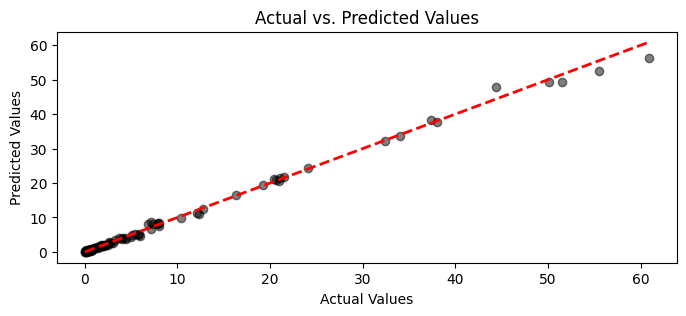

In [34]:
plt.figure(figsize=(8, 3))# Visualize the predicted vs. actual values
plt.scatter(y_test, y_pred, color='black', alpha=0.5)#Scatter plot of predicted vs. actual values
#Add a red dashed line representing actual vs. actual values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')#Set the x-axis label
plt.ylabel('Predicted Values')#Set the y-axis label
plt.title('Actual vs. Predicted Values')#Display the legend
plt.show()#Show the plot

### ExtraTreesRegressor

In [35]:
#Define the CatBoostRegressor model`
et_model = ExtraTreesRegressor()

In [36]:
#Specify the parameter grid for hyperparameter tuning
param_grid_et = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

In [37]:
# Create a grid search object
grid_search_et = GridSearchCV(et_model, param_grid_et, cv=5, scoring='neg_mean_squared_error')

In [38]:
# Fit the grid search to the training data
grid_search_et.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=ExtraTreesRegressor(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [39]:
#Get the best model from the grid search
best_et_model = grid_search_et.best_estimator_


In [40]:
# Make predictions on the test set using the best model
y_pred_et = best_et_model.predict(x_test)

In [41]:
## Calculate and print the Root Mean Squared Error (RMSE) for ExtraTreesRegressor
rmse_et = np.sqrt(mean_squared_error(y_test, y_pred_et))

In [42]:
print(f"Extra Trees - Root Mean Squared Error: {rmse_et:.2f}")#Show the RMSE

Extra Trees - Root Mean Squared Error: 1.05


Result of CatBoostRegressor is  <span style="color:red;">1.06</span>.

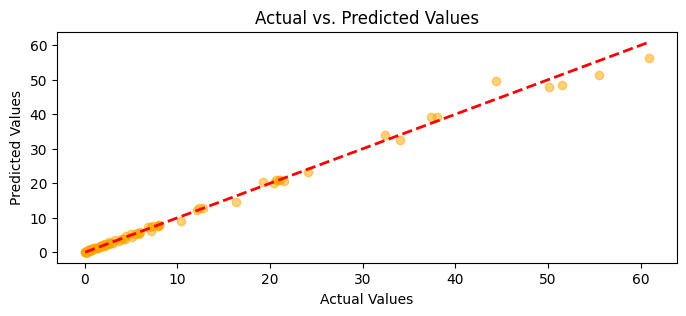

In [43]:
plt.figure(figsize=(8, 3))# Visualize the predicted vs. actual values
plt.scatter(y_test, y_pred_et, color='orange', alpha=0.5)#Scatter plot of predicted vs. actual values
#Add a red dashed line representing actual vs. actual values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')#Set the x-axis label
plt.ylabel('Predicted Values')#Set the y-axis label
plt.title('Actual vs. Predicted Values')#Display the legend
plt.show()#Show the plot

# Support Vector Regression (SVR)

In [44]:
#Define the Support vector regression model
svm_model = SVR()

In [45]:
# Define the parameter grid for grid search
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

In [46]:
# Create grid search objects
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='neg_mean_squared_error')

In [47]:
# Fit the grid search to the training data
grid_search_svm.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='neg_mean_squared_error')

In [48]:
# Get the best estimators from the grid search
best_svm_model = grid_search_svm.best_estimator_

In [49]:
# Make predictions on the test set using the best models
y_pred_svm = best_svm_model.predict(x_test)

In [50]:
# Calculate and print the Root Mean Squared Error (RMSE) for Support vector regression model
rmse_svm = np.sqrt(mean_squared_error(y_test, y_pred_svm))

In [51]:
print(f"SVM - Root Mean Squared Error: {rmse_svm:.2f}")#Show the RMSE

SVM - Root Mean Squared Error: 10.62


Result of CatBoostRegressor is  <span style="color:red;">10.62</span>.

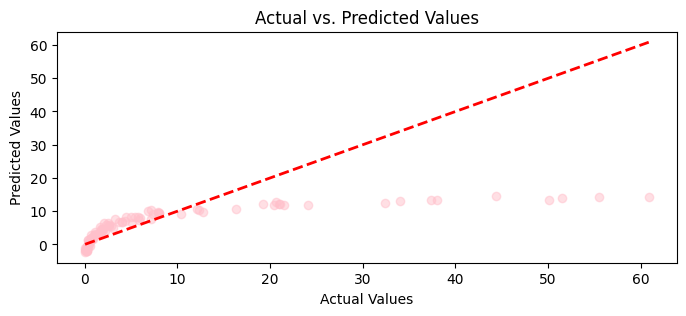

In [52]:
plt.figure(figsize=(8, 3))# Visualize the predicted vs. actual values
plt.scatter(y_test, y_pred_svm, color='pink', alpha=0.5)#Scatter plot of predicted vs. actual values
#Add a red dashed line representing actual vs. actual values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')#Set the x-axis label
plt.ylabel('Predicted Values')#Set the y-axis label
plt.title('Actual vs. Predicted Values')#Display the legend
plt.show()#Show the plot


### RandomForestRegressor

In [53]:
# Create andomForestRegressor models
rf_model = RandomForestRegressor()

In [54]:
# Define the parameter grid for grid search
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

In [55]:
# Create grid search objects
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='neg_mean_squared_error')

In [56]:
# Fit the grid search to the training data
grid_search_rf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [57]:
# Get the best estimators from the grid search
best_rf_model = grid_search_rf.best_estimator_

In [58]:
# Make predictions on the test set using the best models
y_pred_rf = best_rf_model.predict(x_test)

In [59]:
# Calculate and print the Root Mean Squared Error (RMSE) for each model
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

In [60]:
print(f"Random Forest - Root Mean Squared Error: {rmse_rf:.2f}")#Show the RMSE

Random Forest - Root Mean Squared Error: 1.17


Result of CatBoostRegressor is  <span style="color:red;">1.18</span>.

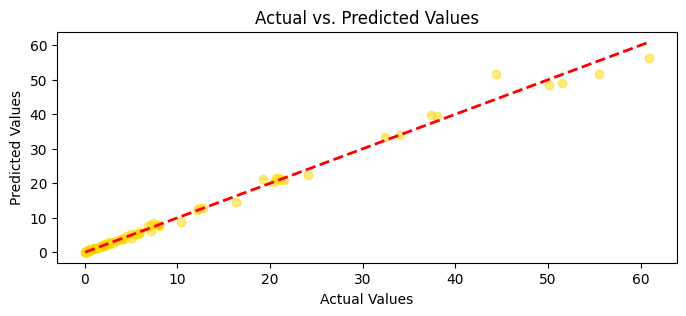

In [61]:
plt.figure(figsize=(8, 3))# Visualize the predicted vs. actual values
plt.scatter(y_test, y_pred_rf, color='Gold', alpha=0.5)#Scatter plot of predicted vs. actual values
#Add a red dashed line representing actual vs. actual values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')#Set the x-axis label
plt.ylabel('Predicted Values')#Set the y-axis label
plt.title('Actual vs. Predicted Values')#Display the legend
plt.show()#Show the plot

### AdaBoostRegressor

In [62]:
# Create models
ab_model = AdaBoostRegressor()

In [63]:
# Define the parameter grid for grid search
param_grid_ab = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [64]:
# Create grid search objects
grid_search_ab = GridSearchCV(ab_model, param_grid_ab, cv=5, scoring='neg_mean_squared_error')

In [65]:
# Fit the grid search to the training data
grid_search_ab.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostRegressor(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [66]:
# Get the best estimators from the grid search
best_ab_model = grid_search_ab.best_estimator_

In [67]:
# Make predictions on the test set using the best models
y_pred_ab = best_ab_model.predict(x_test)

In [68]:
# Calculate and print the Root Mean Squared Error (RMSE) for AdaBoostRegressor
rmse_ab = np.sqrt(mean_squared_error(y_test, y_pred_ab))

In [69]:
print(f"AdaBoost - Root Mean Squared Error: {rmse_ab:.2f}")#Show the RMSE

AdaBoost - Root Mean Squared Error: 1.53


Result of CatBoostRegressor is  <span style="color:red;">1.40</span>.

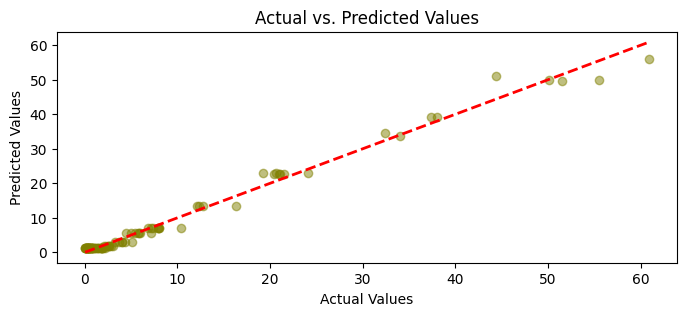

In [70]:
plt.figure(figsize=(8, 3))# Visualize the predicted vs. actual values
plt.scatter(y_test, y_pred_ab, color='Olive', alpha=0.5)#Scatter plot of predicted vs. actual values
#Add a red dashed line representing actual vs. actual values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')#Set the x-axis label
plt.ylabel('Predicted Values')#Set the y-axis label
plt.title('Actual vs. Predicted Values')#Display the legend
plt.show()#Show the plot

## Save the XGBoostRegressor weights

In [71]:
# Save the trained XGBoost model using pickle
with open('xgb_model.pkl', 'wb') as model_file:
    pickle.dump(XGB_best_model, model_file)

## Colorful Model Performance Visualization

Explore the performance summary of different regression models based on their Root Mean Squared Error (RMSE) values. This visualization showcases the varying predictive capabilities of each model.

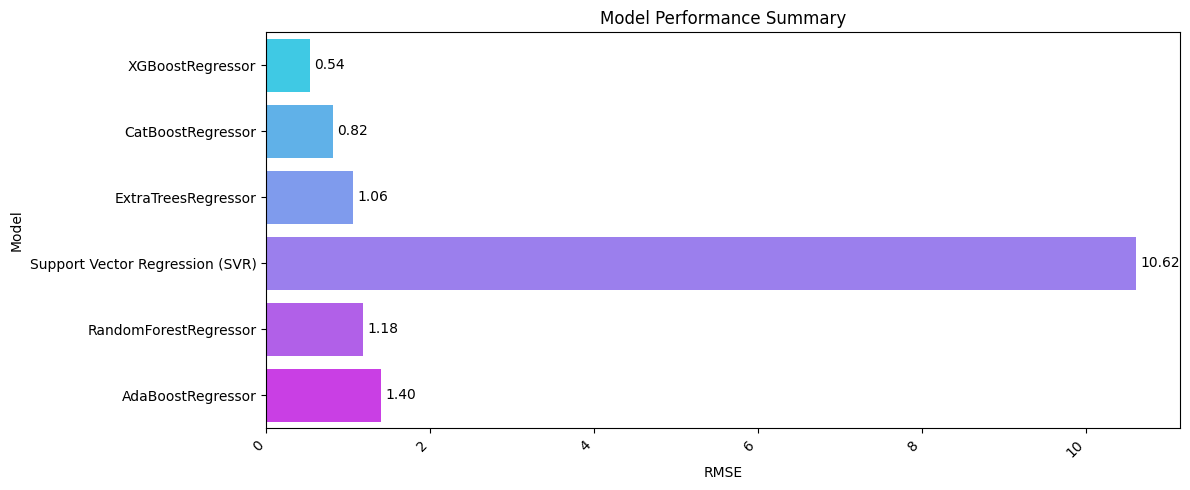

In [72]:
# Data
data = {
    "Model": ["XGBoostRegressor", "CatBoostRegressor", "ExtraTreesRegressor", "Support Vector Regression (SVR)", "RandomForestRegressor", "AdaBoostRegressor"],
    "RMSE": [0.54, 0.82, 1.06, 10.62, 1.18, 1.40],
}

# Create DataFrame
df = pd.DataFrame(data)

# Set color palette
colors = sns.color_palette("cool")

# Create a bar plot
plt.figure(figsize=(12, 5))
sns.barplot(x="RMSE", y="Model", data=df, palette=colors)
plt.xlabel("RMSE")
plt.ylabel("Model")
plt.title("Model Performance Summary")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Add RMSE values as text
for index, row in df.iterrows():
    plt.text(row["RMSE"] + 0.05, index, f"{row['RMSE']:.2f}", va="center", fontsize=10, color="black")

plt.show()


# Conclusion

In this project, we explored the interplay between hull geometry coefficients, the Froude number, and residuary resistance per unit weight of displacement (Rr) in maritime engineering. Through data preprocessing, visualization, and machine learning, we aimed to predict Rr accurately, enhancing our understanding of hydrodynamics.

After thorough analysis, the XGBoost model emerged as the standout performer, yielding the lowest Root Mean Squared Error (RMSE). Leveraging its predictive prowess, we selected XGBoost to make weighty predictions in the context of maritime resistance, benefitting vessel design and efficiency.

